In [1]:
import os
from pathlib import Path

path_cwd = '/nvme/wangding/Desktop/tsim/tsim'
os.chdir(Path(path_cwd).absolute())
os.getcwd()

'/nvme/wangding/Desktop/tsim/tsim'

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
import imageio
from pathlib import Path
from graph.load import load_graph
from eval import *
from graph.process import generate_unique_node_id
import pandas as pd
import os
#import cv2
import pickle
import torch
from matplotlib.pyplot import figure
import math
import numpy as np
plt.style.use('default')
from sklearn.preprocessing import MinMaxScaler
import re
import numpy as np

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import numpy as np
import re

import glob
import pickle
from collections import defaultdict

In [3]:
exp_dir = Path(path_cwd).resolve().parent / "experiment"
exp_dir

PosixPath('/nvme/wangding/Desktop/tsim/experiment')

In [4]:
training_step = 400
pred_step = 100
prev_step = 20
case =  "traci_tls"
test = "test500"
out = "out_dim_100_n_heads_4_n_layer_4_pred_step_100"

sim_feat = load_data(exp_dir,case,test,out,training_step,pred_step)

In [5]:
real_data_dir = exp_dir / case / "data" / test / "test_data"
train_data_dir = exp_dir / case  / "data" / test / "train_data"
node_all = pd.read_csv(train_data_dir / "node_all.csv")
node_id_dict = generate_unique_node_id(node_all)

real_struc, real_feat, node_id_dict, scalers =  load_graph(real_data_dir,0,training_step+pred_step*10,node_id_dict)

In [6]:
sim_feat = unscale_feat(sim_feat, scalers)
real_feat = unscale_feat(real_feat, scalers)

In [8]:
real_feat['lane']

defaultdict(dict,
            {0: {'length': tensor([500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
                      500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
                      500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
                      500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
                      500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
                      500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
                      500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
                      500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
                      500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
                      500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500., 500.,
                      500., 5

### 2. Plot FD for single lane

In [14]:
def get_speed_density_volume(node_id,real_feat):
    volume = real_feat['lane'][node_id]['vehicles'].numpy().flatten()
    occupancy = real_feat['lane'][node_id]['occupancy'].numpy().flatten()
    lane_len = float(real_feat['lane'][node_id]['length'][0])
    
    occupancy = [sum(occupancy[i:i+10]) / 10 for i in range(0, len(occupancy), 10)]
    volume = [sum(volume[i:i+10]) for i in range(0, len(volume), 10)]
    density = [x * lane_len/7 for x in occupancy]
    
    speed = []
    for ai, bi in zip(volume, density):
        if bi == 0:
            speed.append(float('nan'))
        else:
            speed.append(ai*3.6 / bi)

    pairs = [(speed[i], volume[i], density[i],occupancy[i]) for i in range(len(volume))]
    
    return pairs


def plot_FD(node_id, real_feat, sim_feat):
    # Get speed-density-volume data for real and simulated features
    pairs_real = get_speed_density_volume(node_id, real_feat)
    pairs_sim = get_speed_density_volume(node_id, sim_feat)
    
    # Separate data by type
    density_r, speeds_r, volumes_r, occupancy_r = zip(*pairs_real)
    density_s, speeds_s, volumes_s, occupancy_s = zip(*pairs_sim)

    # Plot the scatter plot of all vehicle-occupancy pairs in one plot
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))

    # Plot Occupancy-Volume Diagram
    ax[0].scatter(density_r,volumes_r, alpha=0.7, s=10, color='blue', label='SUMO')
    ax[0].scatter(density_s,volumes_s, alpha=0.7, s=10, color='orange', label='TransWorld')
    ax[0].set_xlabel('Density (veh/km)')
    ax[0].set_ylabel('Volume (veh/h)')
    ax[0].set_title('Volume-Density Diagram')
    ax[0].legend()

    # Plot Speed-Density Diagram
    ax[1].scatter(density_r, speeds_r, alpha=0.7, s=10, color='blue', label='SUMO')
    ax[1].scatter(density_s, speeds_s, alpha=0.7, s=10, color='orange', label='TransWorld')
    ax[1].set_xlabel('Density (veh/km)')
    ax[1].set_ylabel('Speed (km/h)')
    ax[1].set_title('Speed-Density Diagram')
    ax[1].legend()

    # Plot Speed-Volume Diagram
    ax[2].scatter(volumes_r, speeds_r, alpha=0.7, s=10, color='blue', label='SUMO')
    ax[2].scatter(volumes_s, speeds_s, alpha=0.7, s=10, color='orange', label='TransWorld')
    ax[2].set_xlabel('Volume (veh/h)')
    ax[2].set_ylabel('Speed (km/h)')
    ax[2].set_title('Speed-Volume Diagram')
    ax[2].legend()
    
    ax[3].scatter(occupancy_r, volumes_r, alpha=0.7, s=10, color='blue', label='SUMO')
    ax[3].scatter(occupancy_s, volumes_s, alpha=0.7, s=10, color='orange', label='TransWorld')
    ax[3].set_xlabel('Occupancy (veh/km)')
    ax[3].set_ylabel('Volume (veh/h)')
    ax[3].set_title('Occupancy-Volume Diagram')
    ax[3].legend()

    plt.tight_layout()
    plt.show()


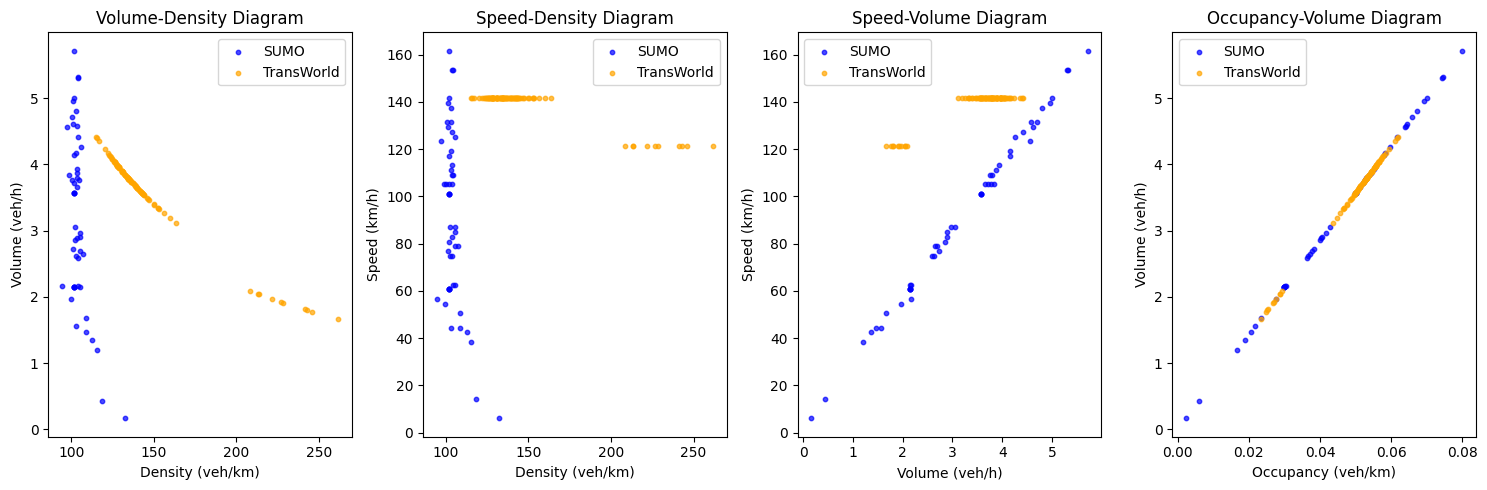

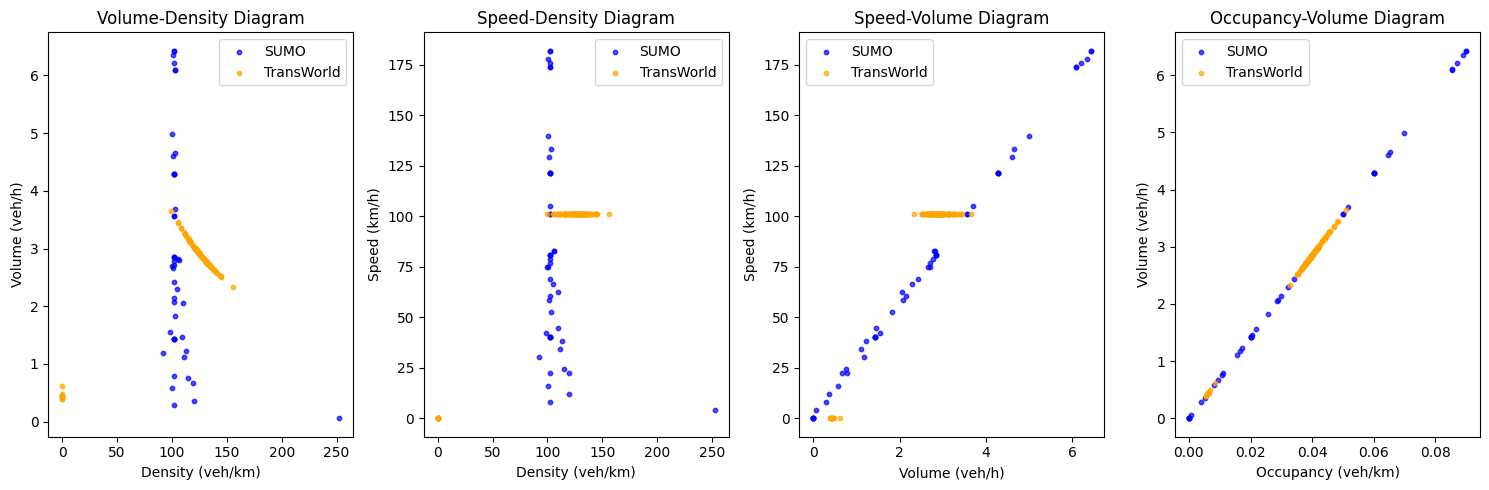

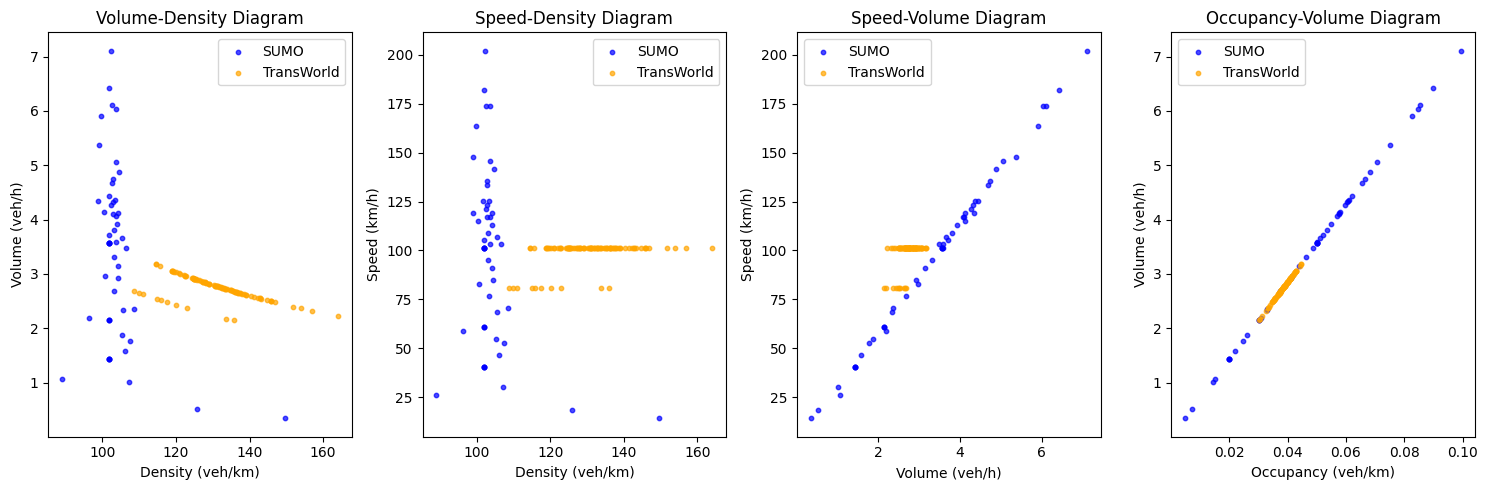

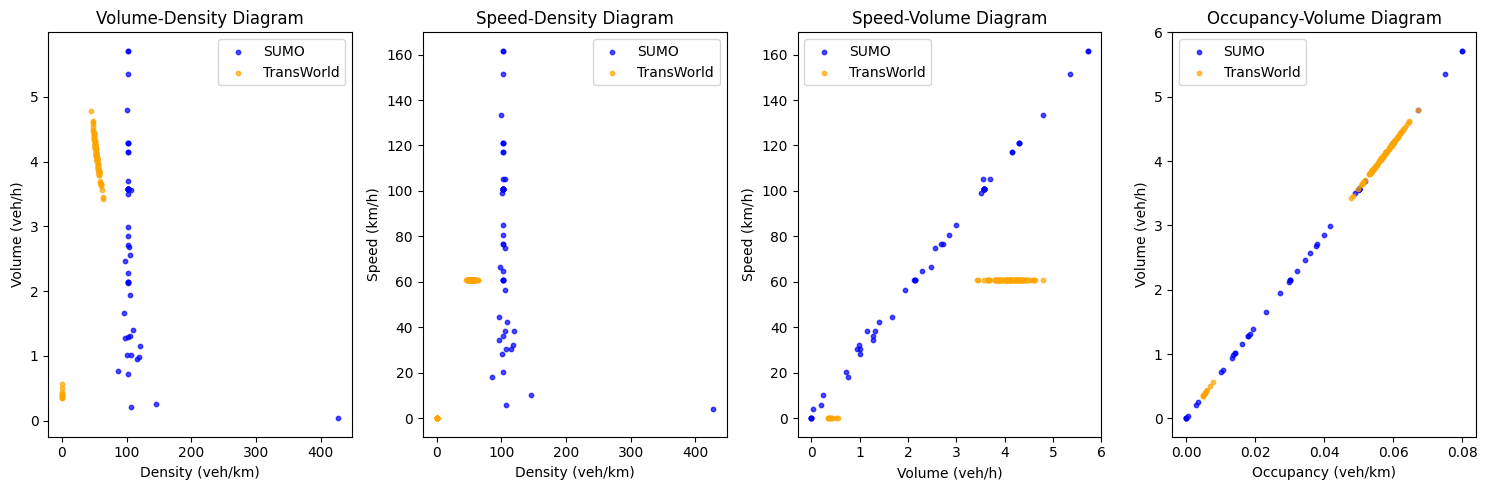

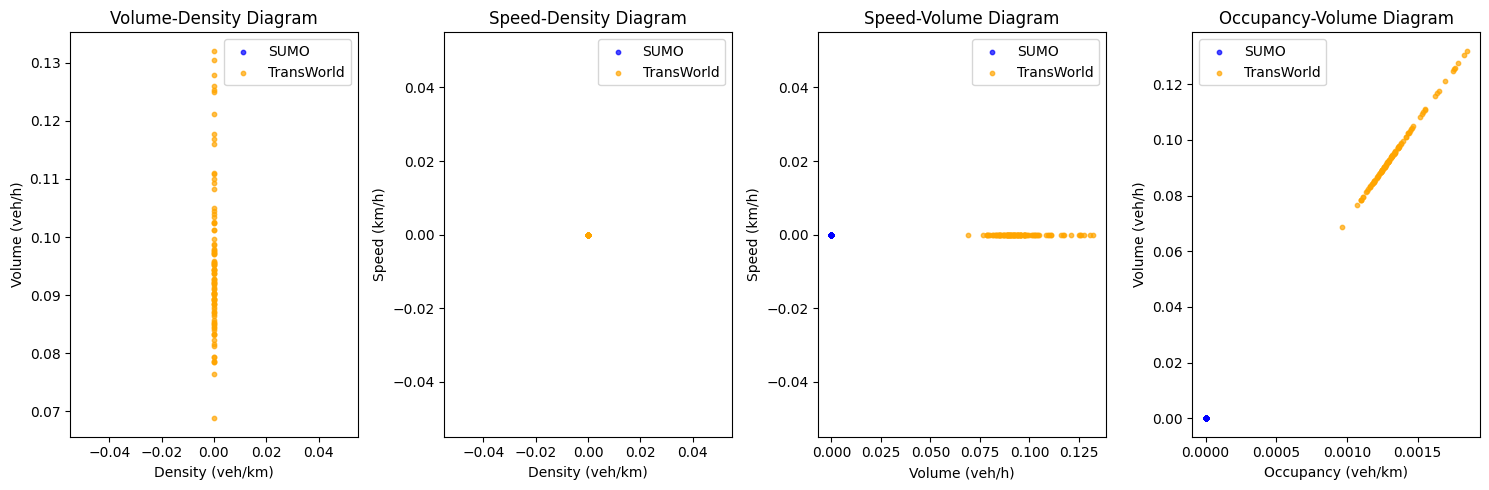

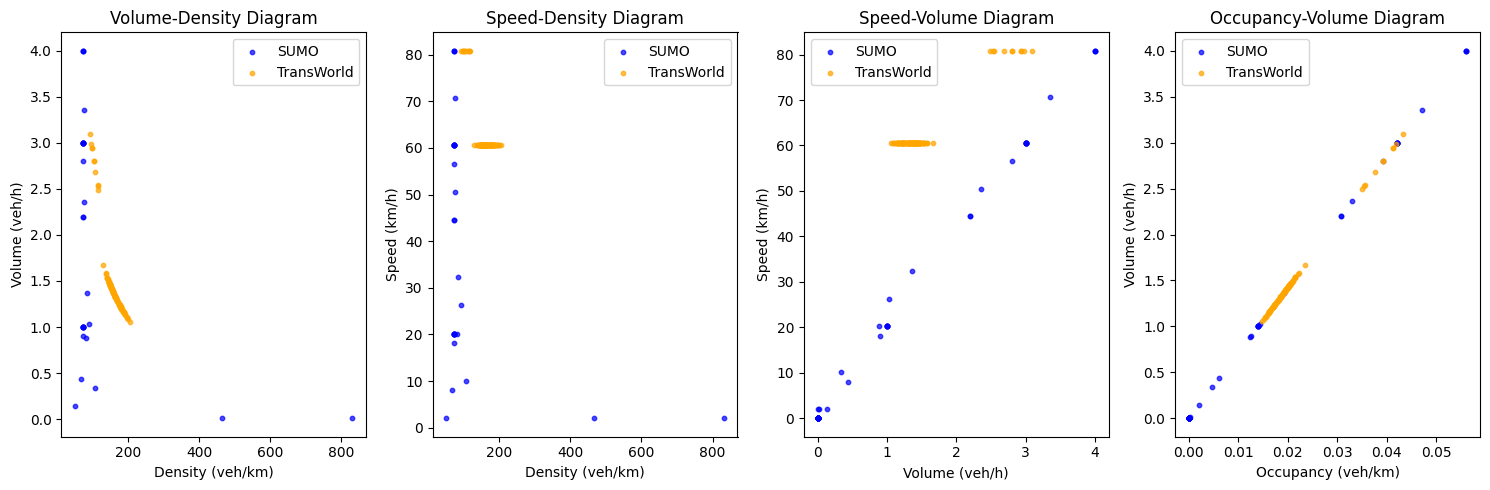

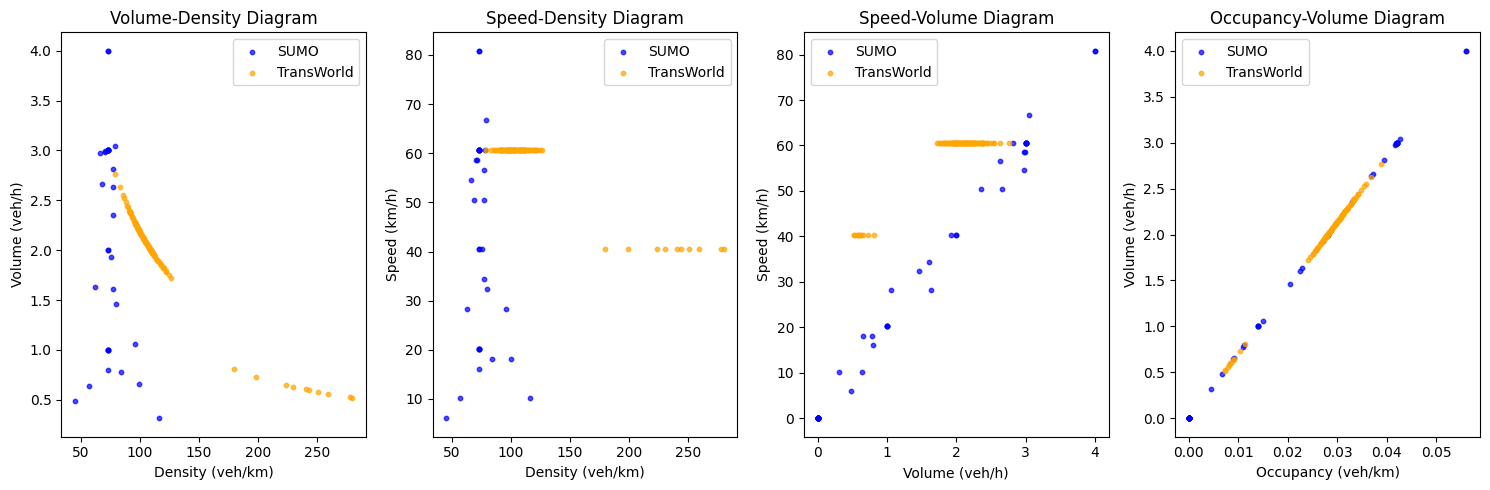

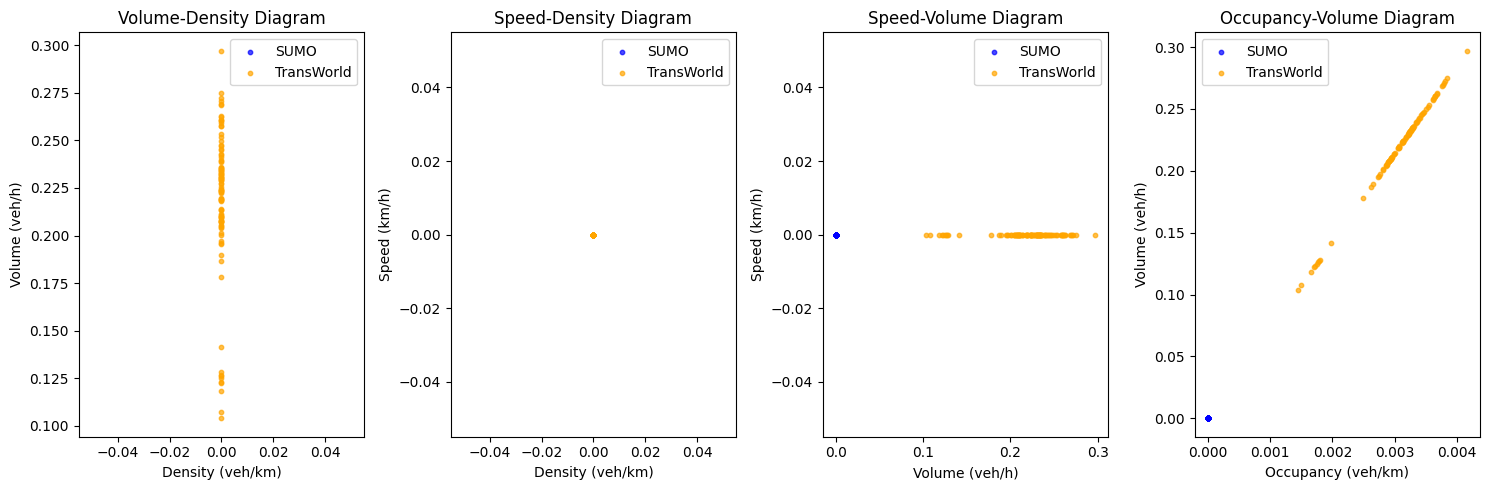

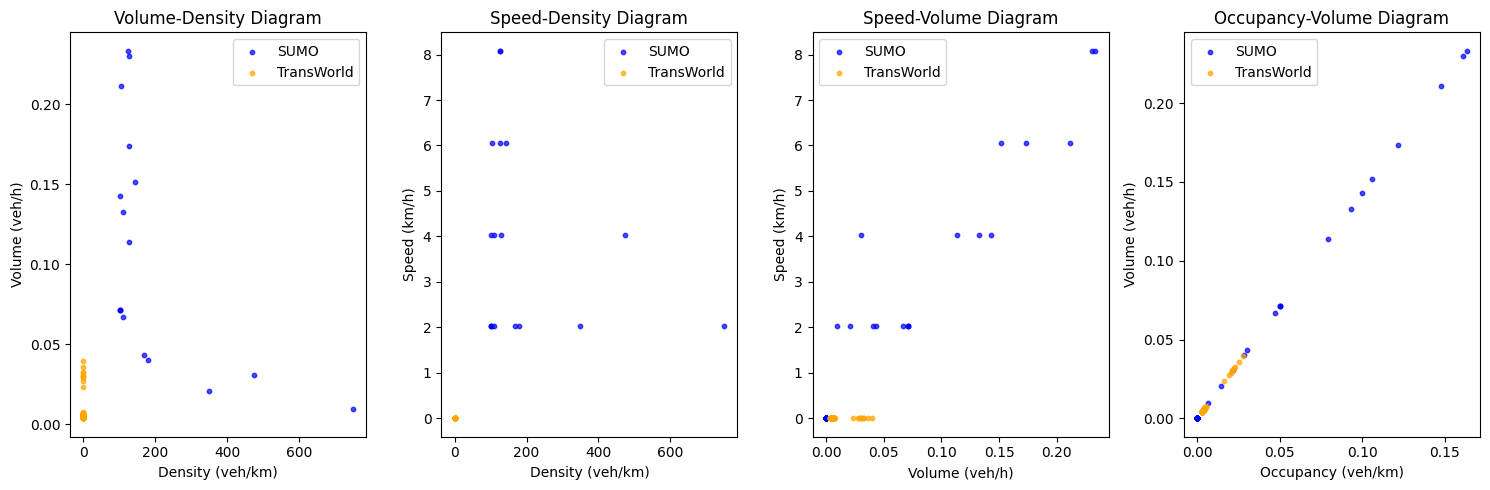

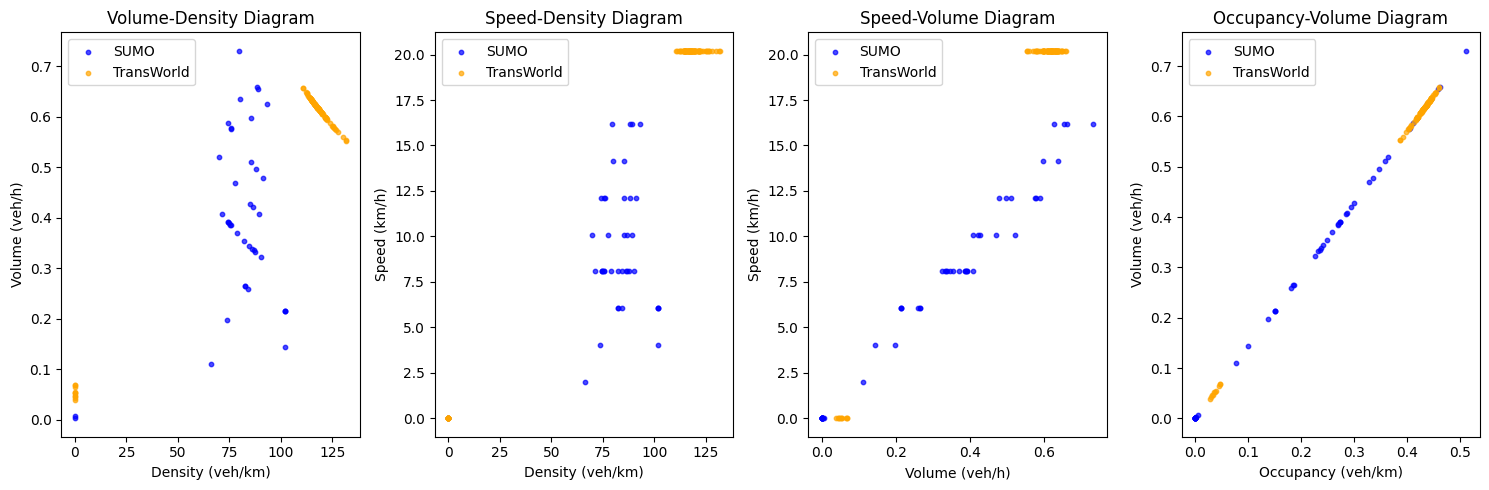

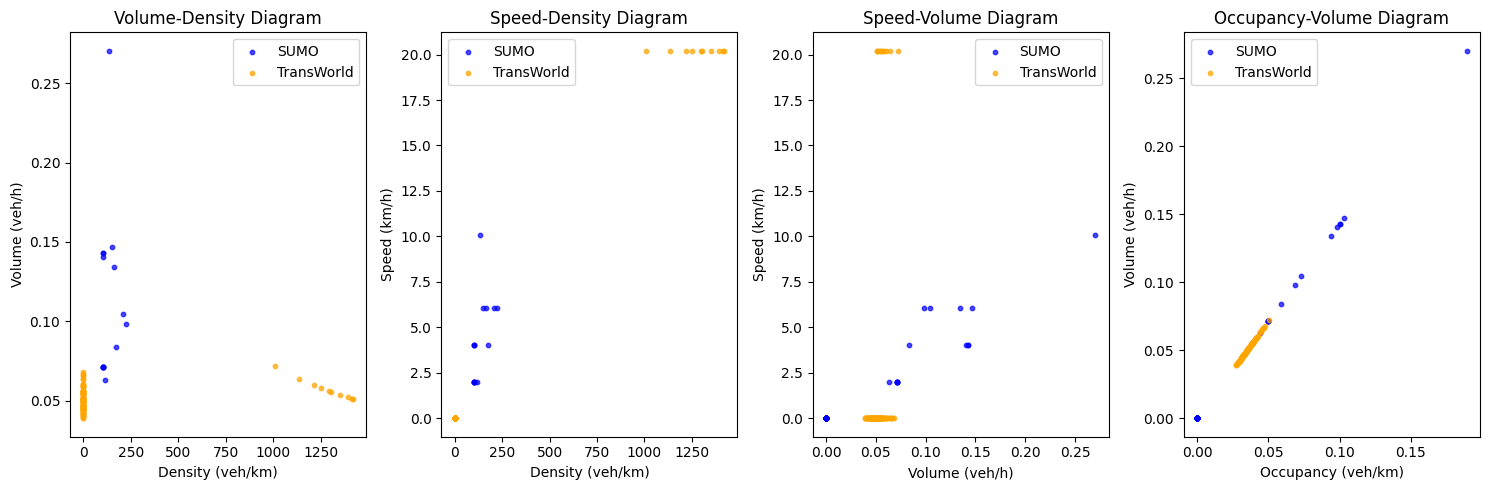

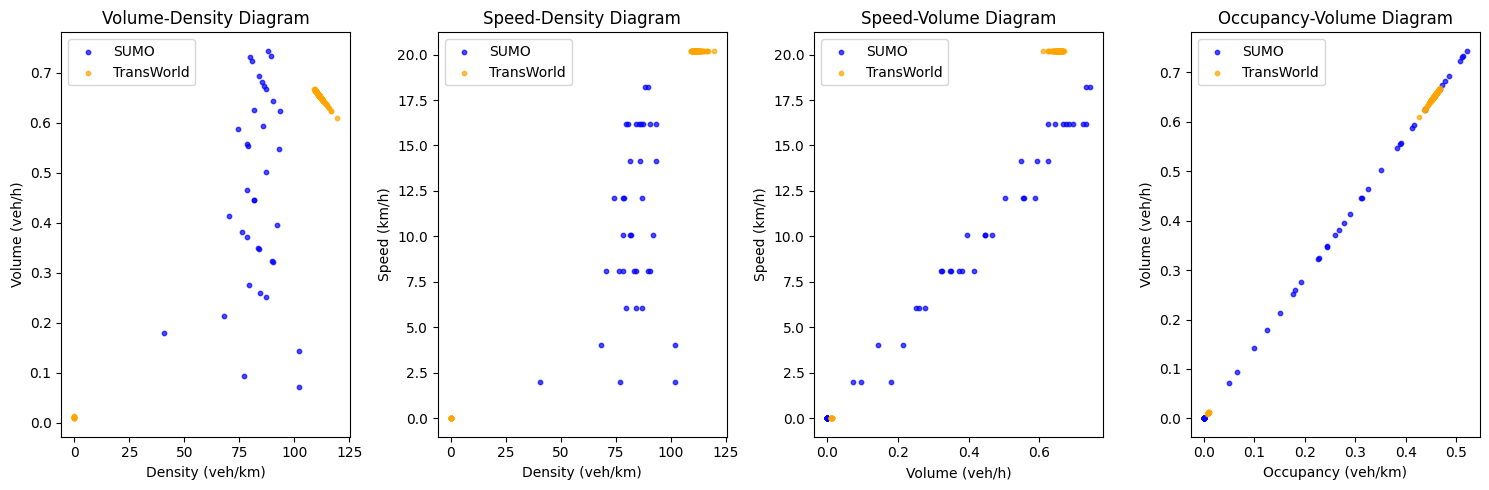

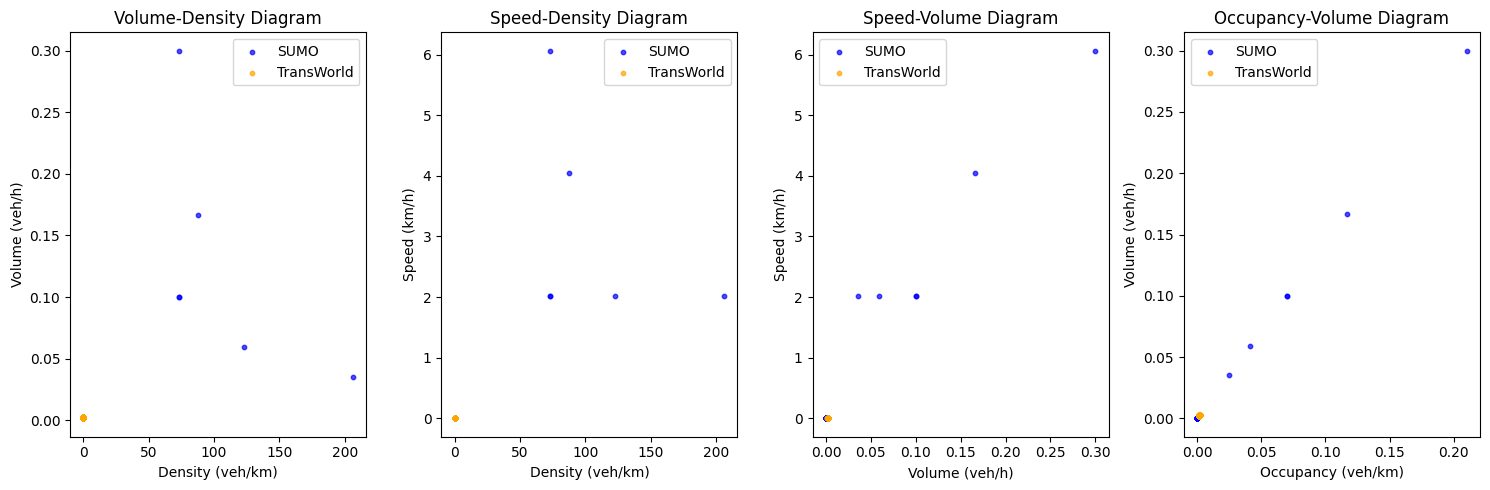

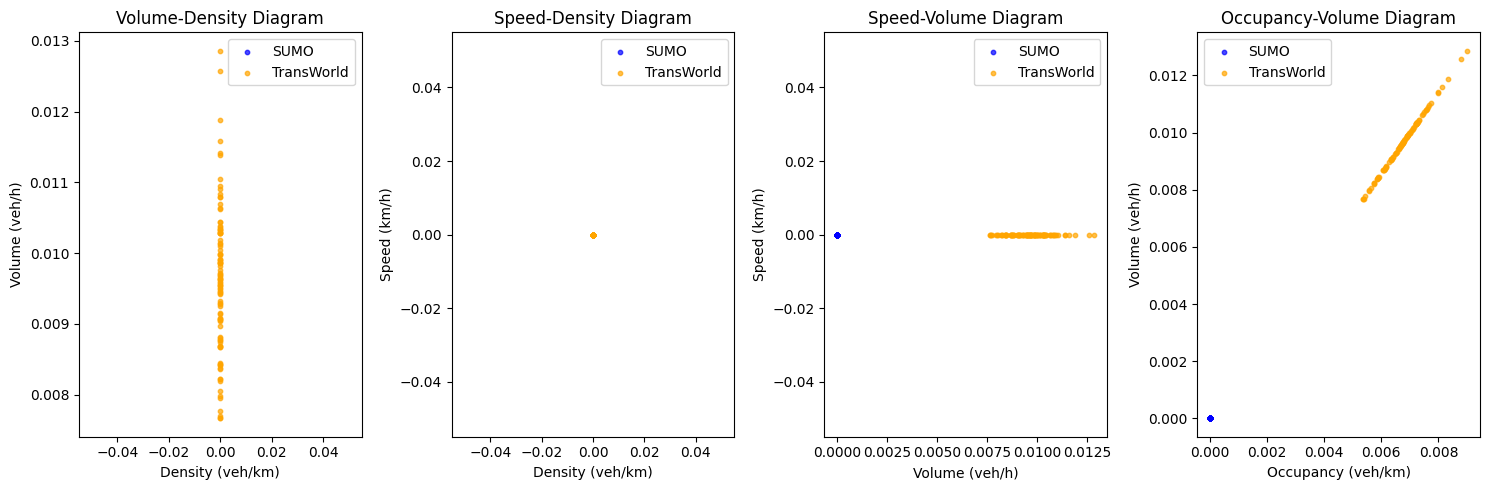

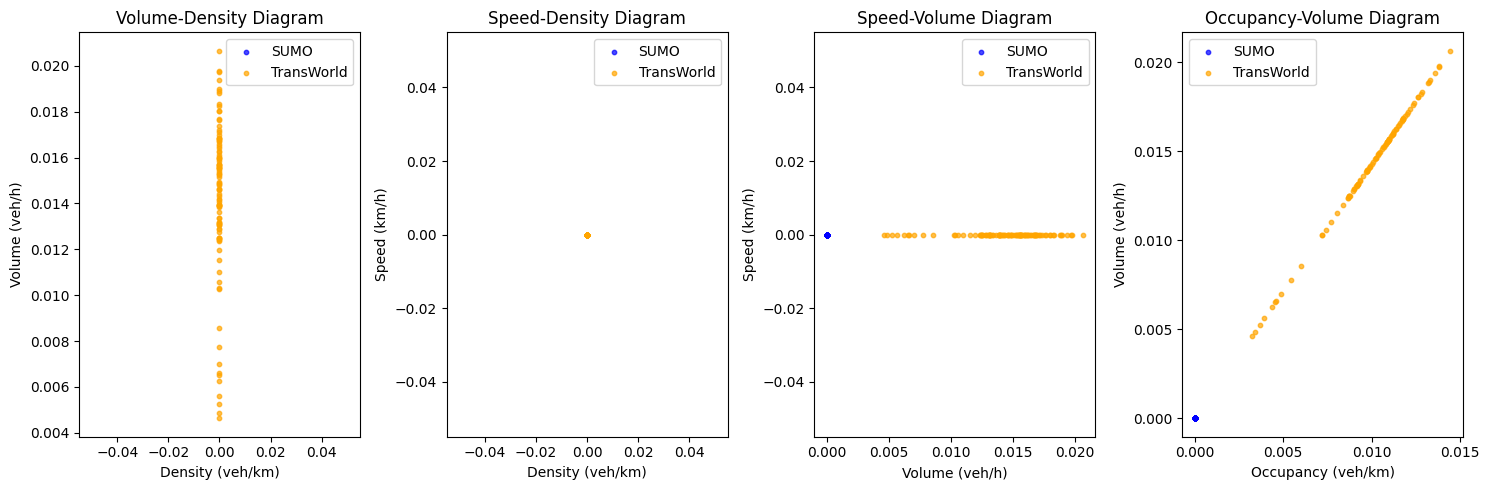

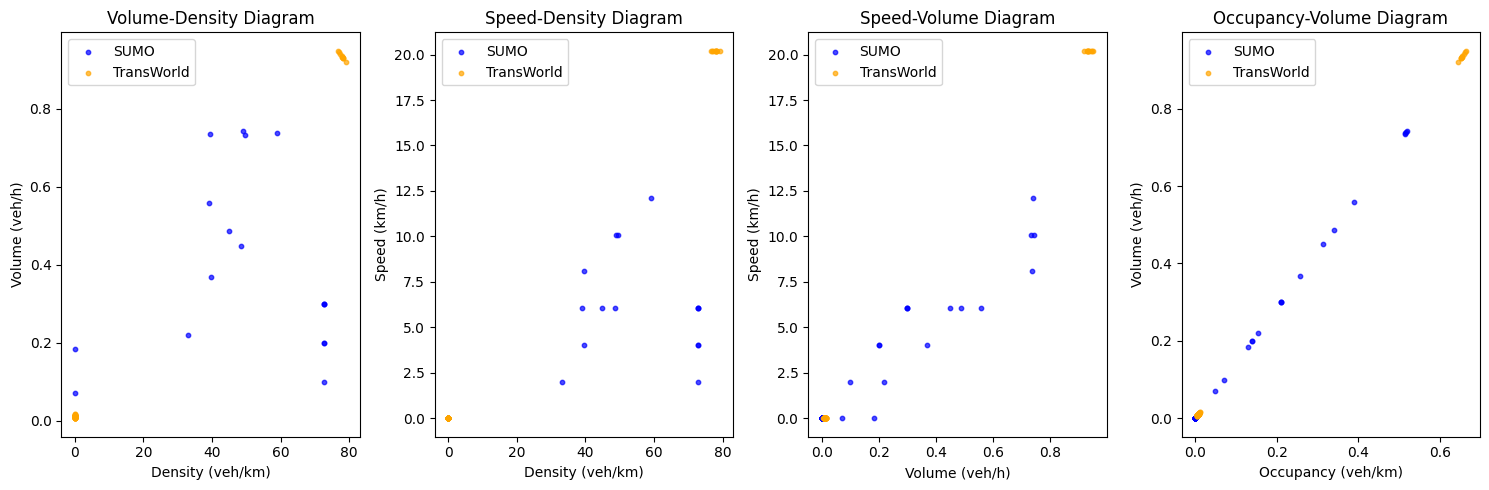

In [15]:
node_id = 0
for node_id in real_feat['lane'].keys():
    plot_FD(node_id, real_feat, sim_feat)

In [28]:
real_feat['lane']['node_id'].keys()

dict_keys([])

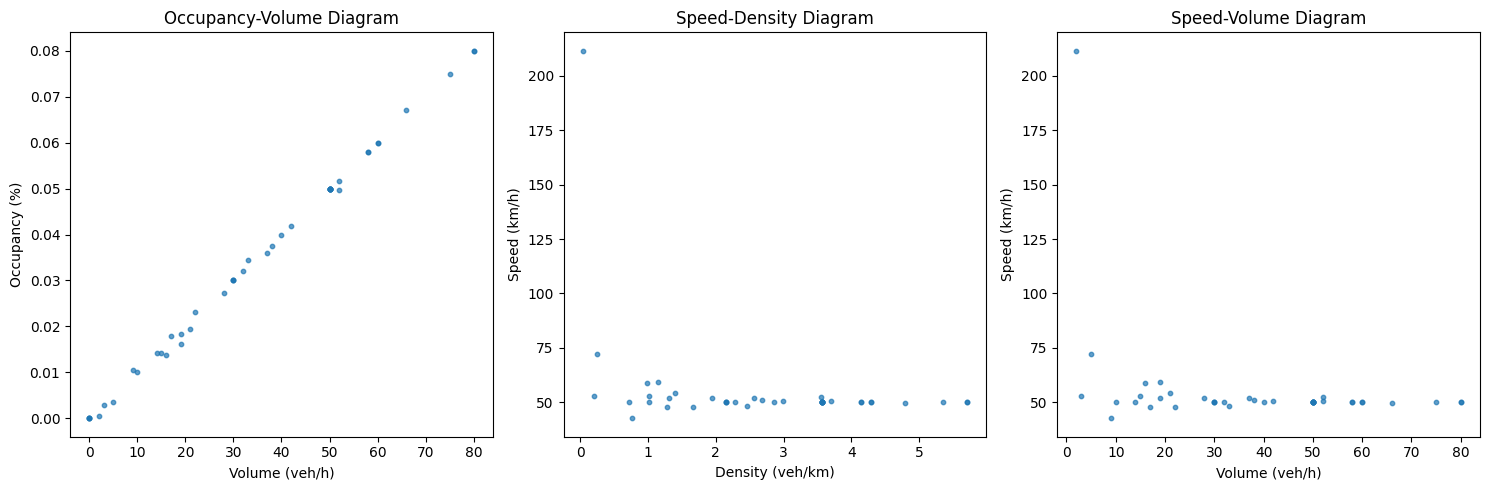

In [11]:


# Get the vehicles and occupancy data for the current node ID
node_id = 3
volume = real_feat['lane'][node_id]['vehicles'].numpy().flatten()
occupancy = real_feat['lane'][node_id]['occupancy'].numpy().flatten()
lane_len = float(real_feat['lane'][node_id]['length'][0])

occupancy = [sum(occupancy[i:i+10])/10 for i in range(0, len(occupancy), 10)]
volume = [sum(volume[i:i+10]) for i in range(0, len(volume), 10)]
density = [x * lane_len/7 for x in occupancy]

speed = []
for ai, bi in zip(volume, density):
    if bi == 0:
        speed.append(float('nan'))
    else:
        speed.append(ai*3.6 / bi)

# Create a list of tuples with the vehicle-occupancy pairs
pairs = [(speed[i], volume[i], density[i]) for i in range(len(volume))]

# Plot the scatter plot of all vehicle-occupancy pairs in one plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

ax[0].scatter(volume, occupancy, alpha=0.7, s=10)
ax[0].set_xlabel('Volume (veh/h)')
ax[0].set_ylabel('Occupancy (%)')
ax[0].set_title('Occupancy-Volume Diagram')
# ax[0].set_xlim(0, max(volume)*1.1)
# ax[0].set_ylim(0, max(occupancy)*1.1)

ax[1].scatter(density, speed, alpha=0.7, s=10)
ax[1].set_xlabel('Density (veh/km)')
ax[1].set_ylabel('Speed (km/h)')
ax[1].set_title('Speed-Density Diagram')
# ax[1].set_xlim(0, max(density)*1.1)
# ax[1].set_ylim(0, max(speed)*1.1)

ax[2].scatter(volume, speed, alpha=0.7, s=10)
ax[2].set_xlabel('Volume (veh/h)')
ax[2].set_ylabel('Speed (km/h)')
ax[2].set_title('Speed-Volume Diagram')
# ax[2].set_xlim(0, max(volume)*1.1)
# ax[2].set_ylim(0, max(speed)*1.1)

plt.tight_layout()
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

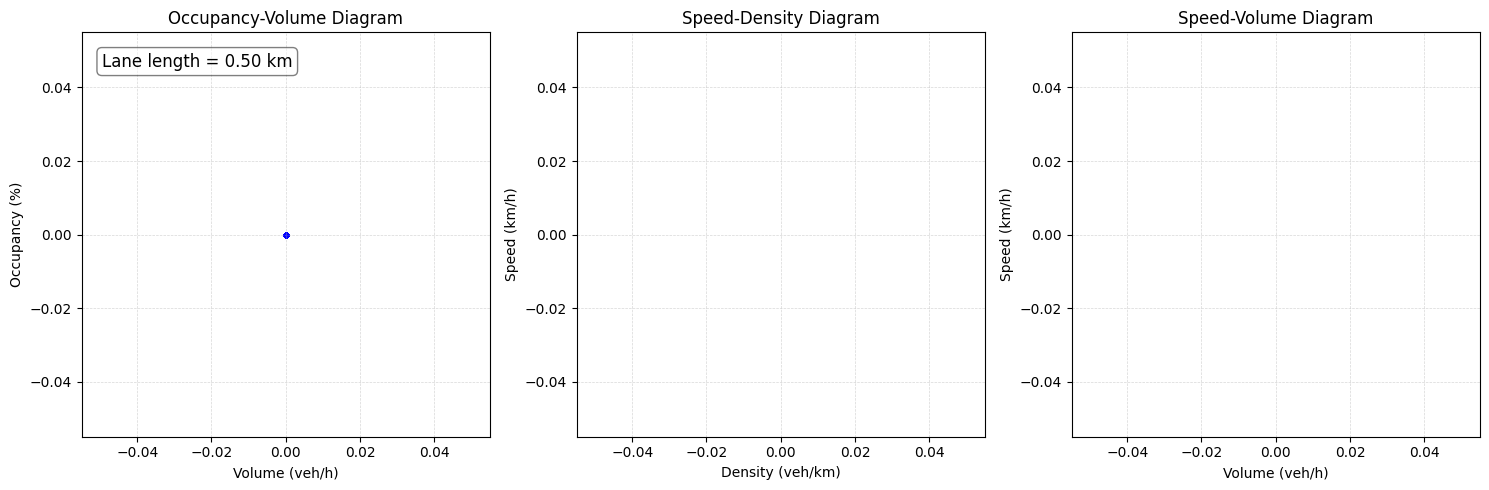

In [12]:
import matplotlib.pyplot as plt

#Get the vehicles and occupancy data for the current node ID
node_id = 4
volume = real_feat['lane'][node_id]['vehicles'].numpy().flatten()
occupancy = real_feat['lane'][node_id]['occupancy'].numpy().flatten()
lane_len = float(real_feat['lane'][node_id]['length'][0])

#Compute density and speed
occupancy = [sum(occupancy[i:i+10])/10 for i in range(0, len(occupancy), 10)]
volume = [sum(volume[i:i+10]) for i in range(0, len(volume), 10)]
density = [x * lane_len/7 for x in occupancy]

speed = []
for ai, bi in zip(volume, density):
    if bi == 0:
        speed.append(float('nan'))
    else:
        speed.append(ai*3.6 / bi)

#Create a list of tuples with the vehicle-occupancy pairs
pairs = [(speed[i], volume[i], density[i]) for i in range(len(volume))]

#Set up the plot
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

#Plot the occupancy-volume diagram
ax[0].scatter(volume, occupancy, alpha=0.7, s=10, color='blue')
ax[0].set_xlabel('Volume (veh/h)')
ax[0].set_ylabel('Occupancy (%)')
ax[0].set_title('Occupancy-Volume Diagram')
ax[0].grid(ls='--', lw=0.5, alpha=0.5)

#Plot the speed-density diagram
ax[1].scatter(density, speed, alpha=0.7, s=10, color='red')
ax[1].set_xlabel('Density (veh/km)')
ax[1].set_ylabel('Speed (km/h)')
ax[1].set_title('Speed-Density Diagram')
ax[1].grid(ls='--', lw=0.5, alpha=0.5)

#Plot the speed-volume diagram
ax[2].scatter(volume, speed, alpha=0.7, s=10, color='green')
ax[2].set_xlabel('Volume (veh/h)')
ax[2].set_ylabel('Speed (km/h)')
ax[2].set_title('Speed-Volume Diagram')
ax[2].grid(ls='--', lw=0.5, alpha=0.5)

#Set the limits for all axes
# xlim = max(volume) * 1.1
# ylim1 = max(occupancy) * 1.1
# ylim2 = max(speed) * 1.1
# ax[0].set_xlim(0, xlim)
# ax[0].set_ylim(0, ylim1)
# ax[1].set_xlim(0, xlim / 7)
# ax[1].set_ylim(0, ylim2)
# ax[2].set_xlim(0, xlim)
# ax[2].set_ylim(0, ylim2)

#Add a text box with the lane length
textstr = 'Lane length = {:.2f} km'.format(lane_len / 1000)
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
ax[0].text(0.05, 0.95, textstr, transform=ax[0].transAxes,
fontsize=12, verticalalignment='top', bbox=props)

#Adjust the layout and save the figure
plt.tight_layout()
# plt.savefig('traffic_diagrams.png')
plt.show

### 3. Plot MFD

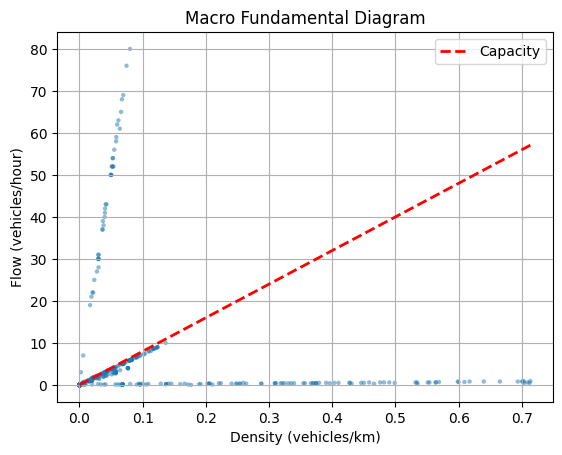

In [20]:
# Step 1: Iterate over all node IDs to collect the vehicle-occupancy data
all_pairs = []
for node_id in real_feat['lane']:
    volume = real_feat['lane'][node_id]['vehicles'].numpy().flatten()
    occupancy = real_feat['lane'][node_id]['occupancy'].numpy().flatten()
    lane_len = float(real_feat['lane'][node_id]['length'][0])

    # Aggregate data into 10-second intervals to reduce noise
    occupancy = [sum(occupancy[i:i+10])/10 for i in range(0, len(occupancy), 10)]
    volume = [sum(volume[i:i+10]) for i in range(0, len(volume), 10)]
    density = occupancy #[x * lane_len/7 for x in occupancy]

    # Calculate speed from volume and density
    speed = []
    for ai, bi in zip(volume, density):
        if bi == 0:
            speed.append(float('nan'))
        else:
            speed.append(ai*3.6 / bi) 

    # Append vehicle-occupancy pairs to list
    pairs = [(speed[i], volume[i], density[i]) for i in range(len(volume))]
    all_pairs.extend(pairs)

# Step 2: Combine data from all nodes into a single list of tuples
all_pairs = sorted(all_pairs, key=lambda x: x[2])  # sort by density

# Step 3: Sort the list by density
density = [x[2] for x in all_pairs]
flow = [x[1] for x in all_pairs]

# Step 4: Plot the MFD
fig, ax = plt.subplots()
ax.scatter(density, flow, s=10, alpha=0.5, edgecolors='none')
ax.set_xlabel('Density (vehicles/km)')
ax.set_ylabel('Flow (vehicles/hour)')
ax.set_title('Macro Fundamental Diagram')
ax.grid(True)

# Step 5: Add the capacity curve
max_flow = max(flow)
capacities = []
for d in density:
    capacities.append(min(d*max_flow, max_flow))
ax.plot(density, capacities, 'r--', linewidth=2, label='Capacity')
ax.legend()

plt.show()


In [43]:
for node_id in list(real_feat['lane'].keys()):
    node_type = "lane"
    feat_name1 = "occupancy"
    feat_name2 = "vehicles"

    lane_len = float(real_feat['lane'][node_id]['length'][0])*(max_len-min_len)+min_len
    feat_real1 = get_feat_df(real_feat, node_type, node_id, feat_name1)
    feat_real2 = get_feat_df(real_feat, node_type, node_id, feat_name2)
    df = pd.merge(feat_real1,feat_real2,on="time")
    occupancy = df[feat_name1+str(node_id)]
    occupancy = [sum(occupancy[i:i+10])/10 for i in range(0, len(occupancy), 10)]
    volume = df[feat_name2+str(node_id)]*(max_vol-min_vol)+min_vol
    volume = [sum(volume[i:i+10]) for i in range(0, len(volume), 10)]
    density = [x * lane_len/7 for x in occupancy]
    
    speed = []
    for ai, bi in zip(volume, density):
        if bi == 0:
            speed.append(float('nan'))
        else:
            speed.append(ai*3.6 / bi)
        
    
    # create a figure with three subplots
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))

    # plot the data in the first subplot
    axs[0].scatter(volume,speed)
    axs[0].set_title('volume,speed')
    axs[0].set_xlabel("volume")
    axs[0].set_ylabel("speed")
    # axs[0].set_ylim(0,20)

    # plot the data in the second subplot
    axs[1].scatter(density,volume)
    axs[1].set_title('density,volume')
    axs[1].set_xlabel("density")
    axs[1].set_ylabel("volume")

    # plot the data in the third subplot
    axs[2].scatter(density,speed)
    axs[2].set_title('density,speed')
    axs[2].set_xlabel("density")
    axs[2].set_ylabel("speed")

    # add a title to the entire figure
    fig.suptitle('Fundamental Diagram of Lane:'+str(node_id))

    # adjust the spacing between the subplots
    fig.tight_layout()

    # show the plot
    plt.show()
    #plt.savefig(out_dir / "LANE_{s}.png".format(s=node_id), format="PNG",)




    

NameError: name 'max_len' is not defined

In [112]:

common_keys = list(real_feat['veh'].keys() & sim_feat['veh'].keys())

/tmp/ipykernel_108700/3897183209.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))


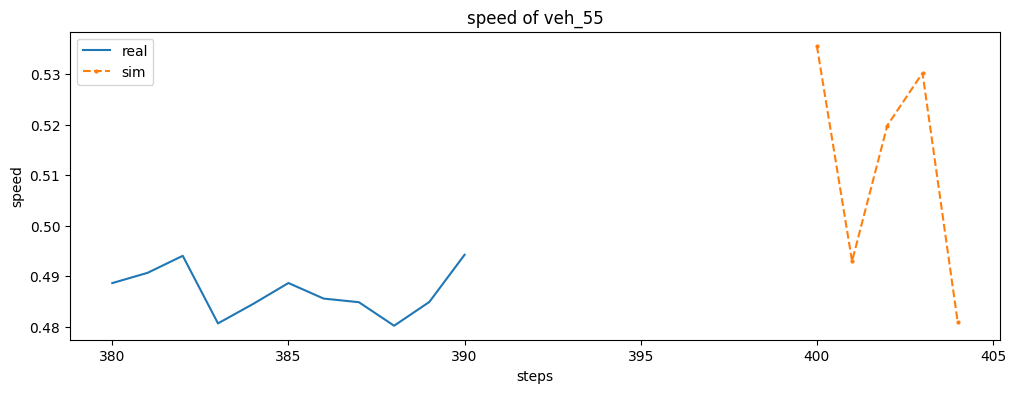

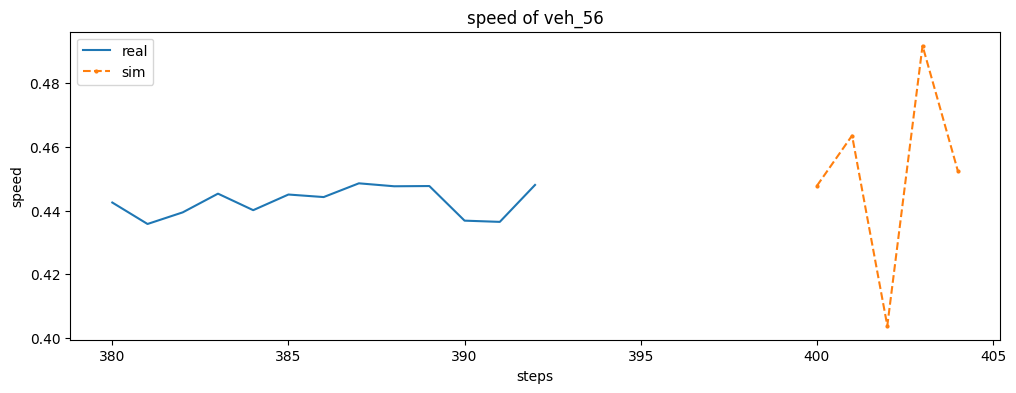

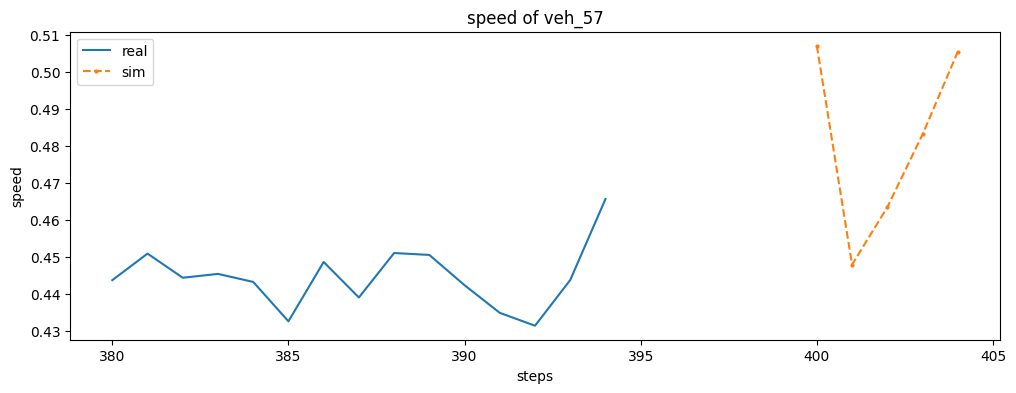

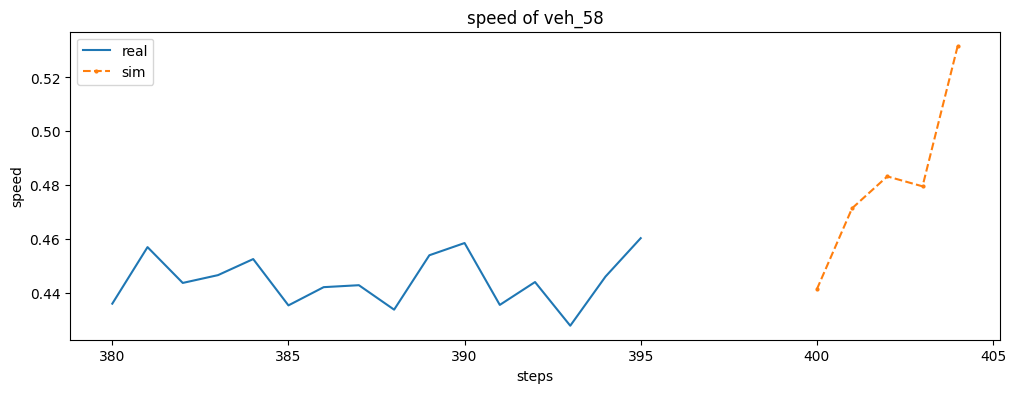

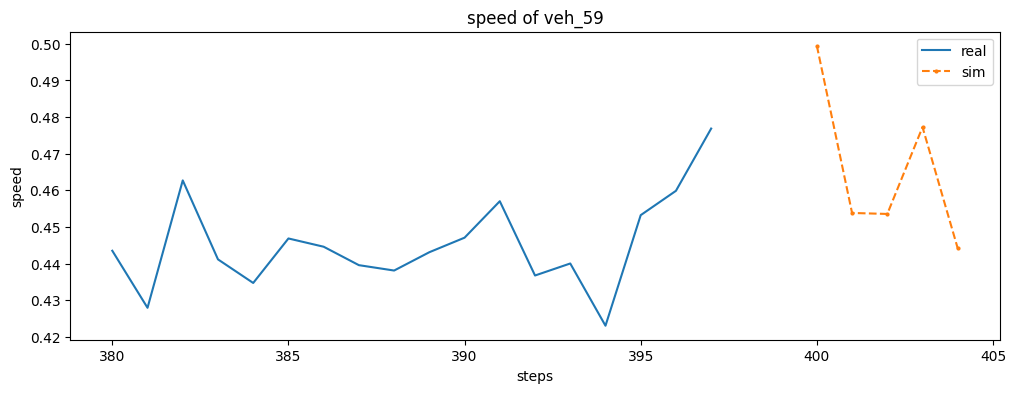

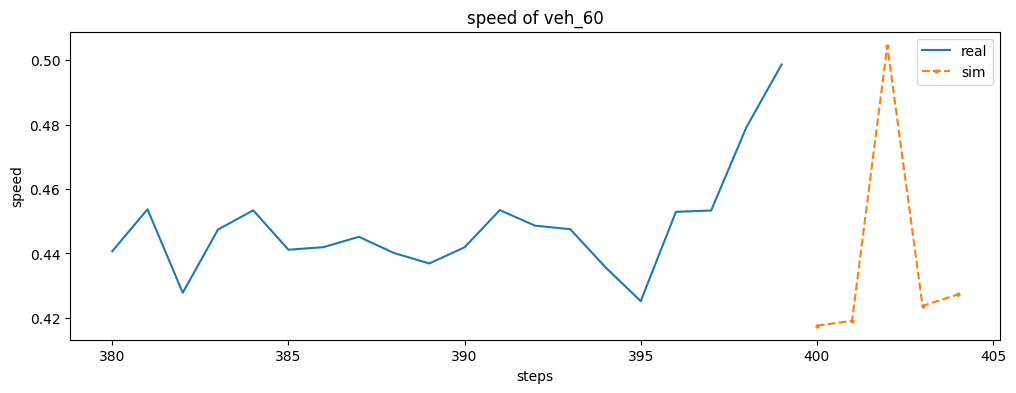

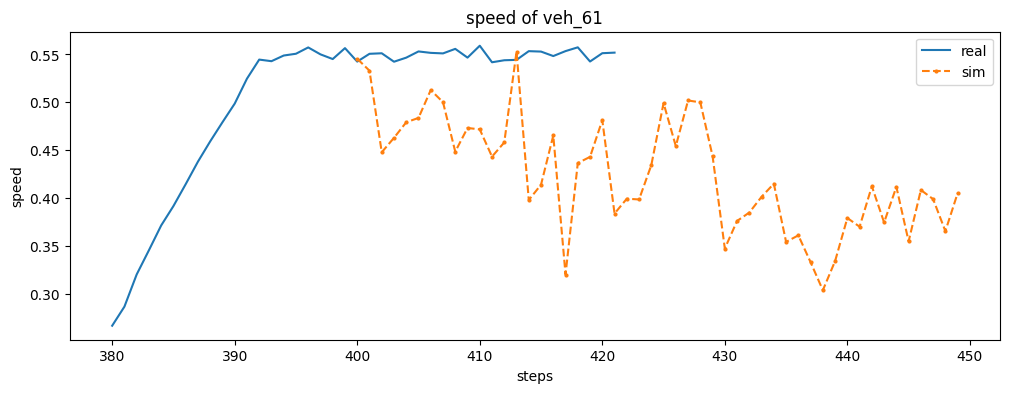

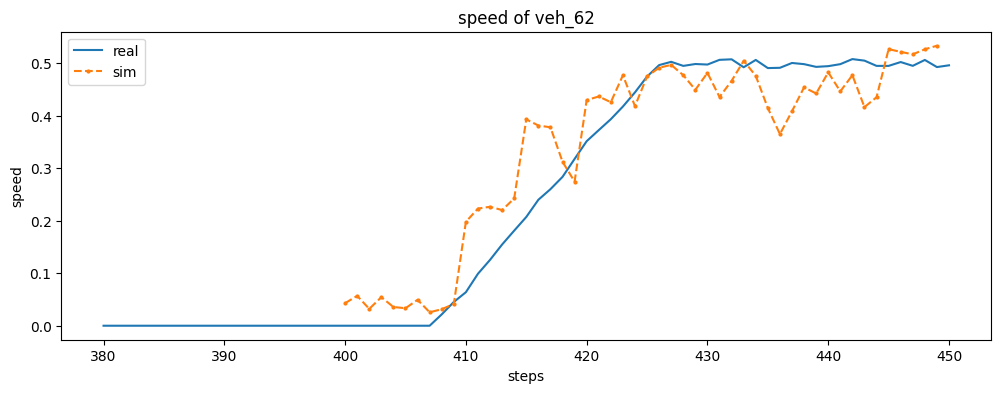

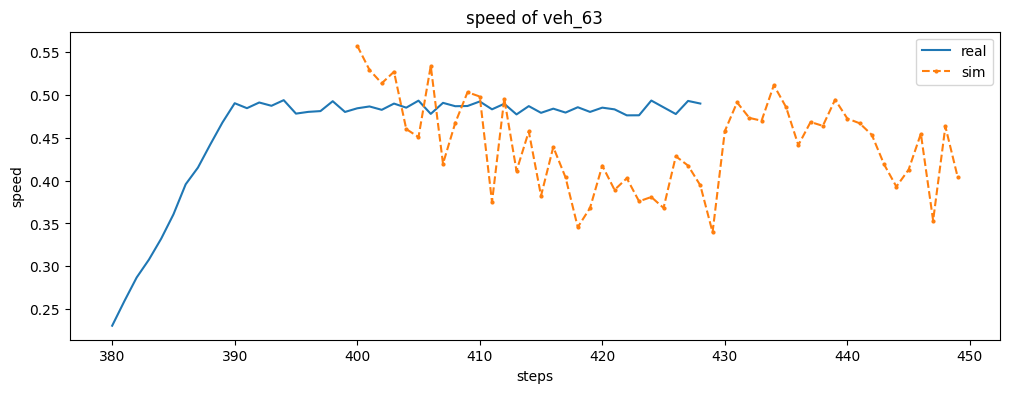

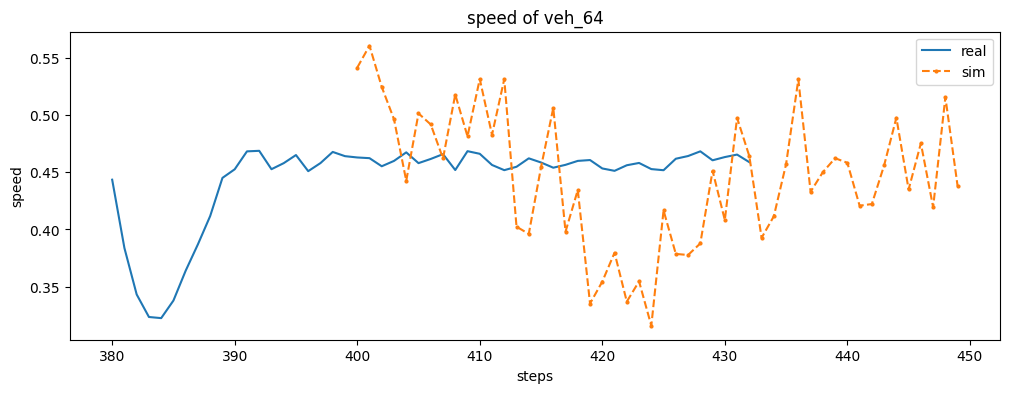

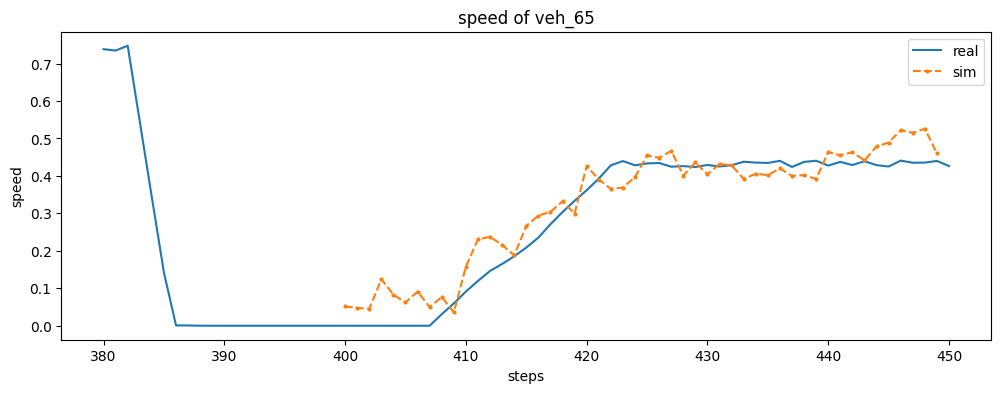

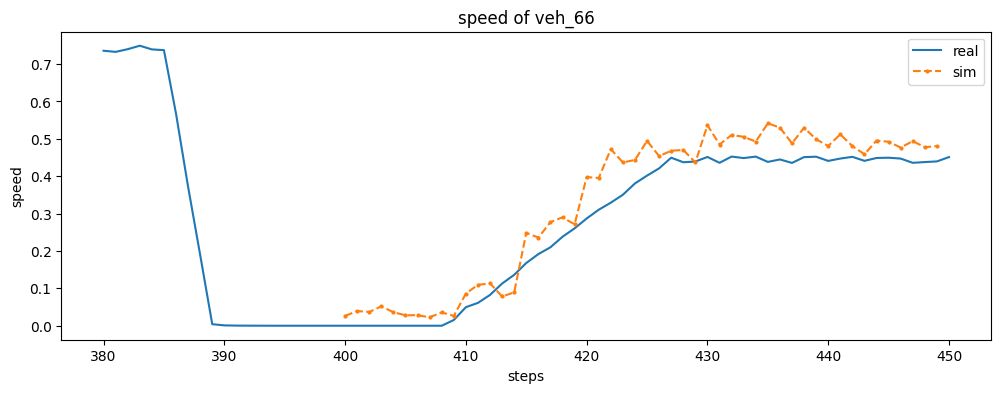

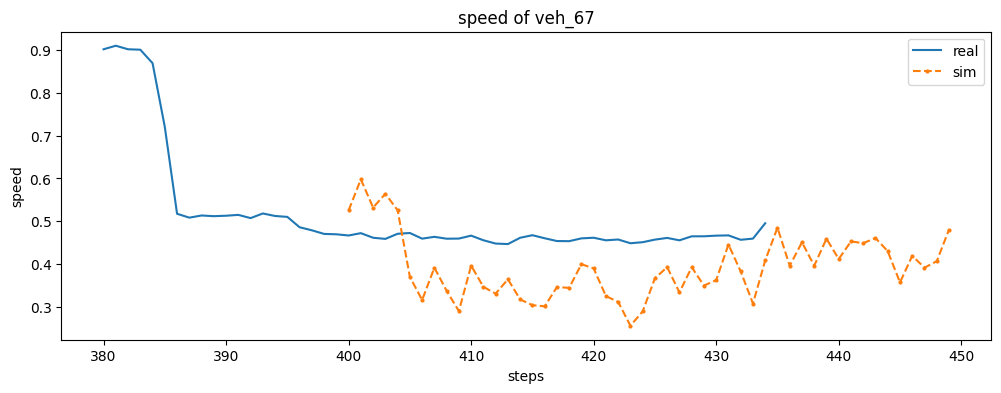

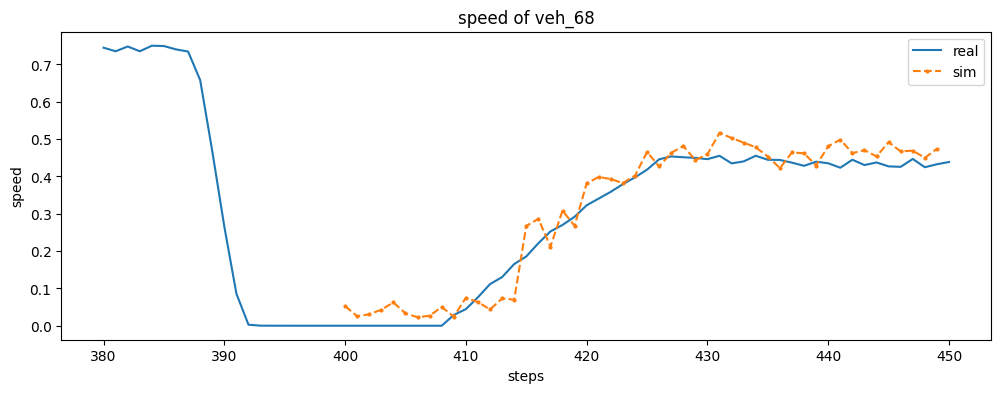

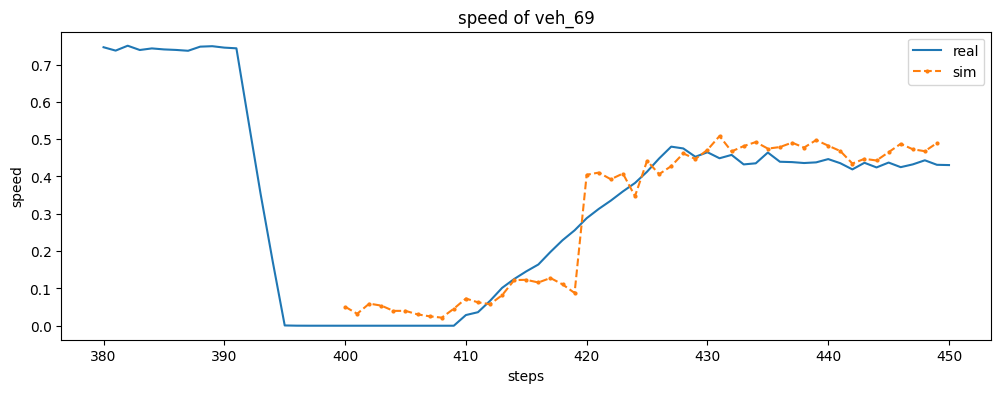

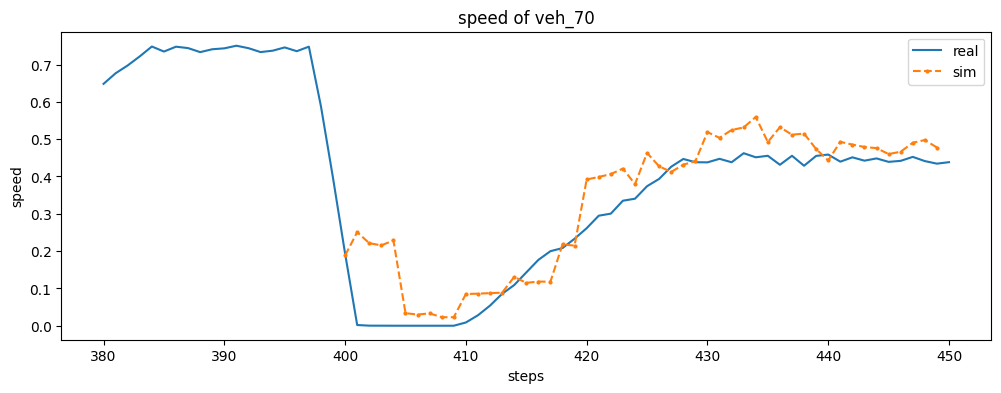

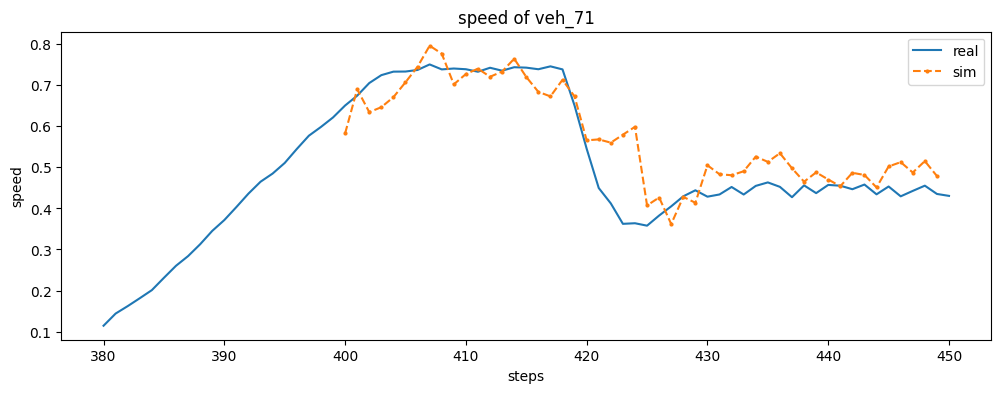

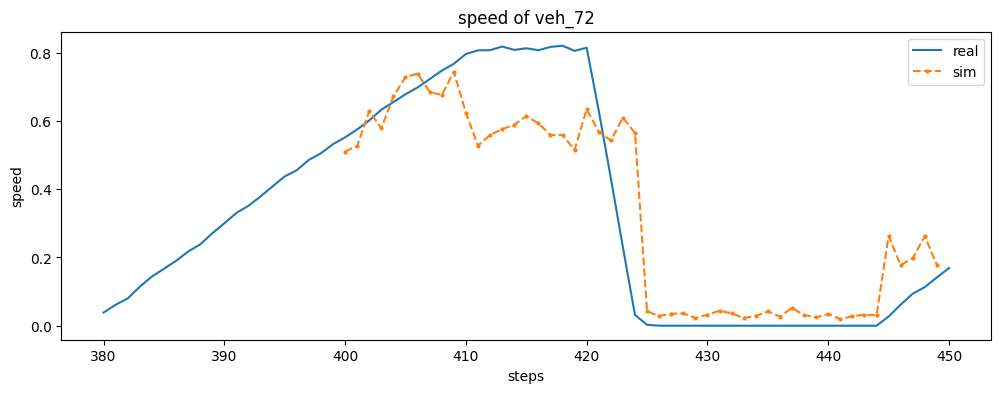

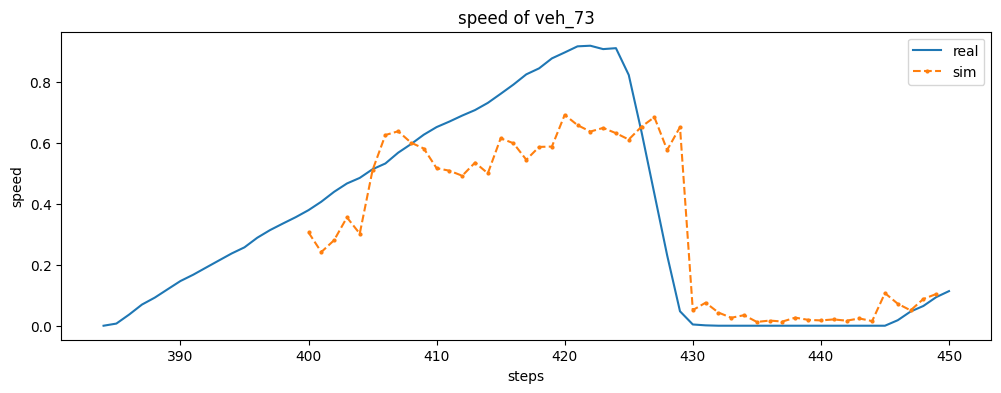

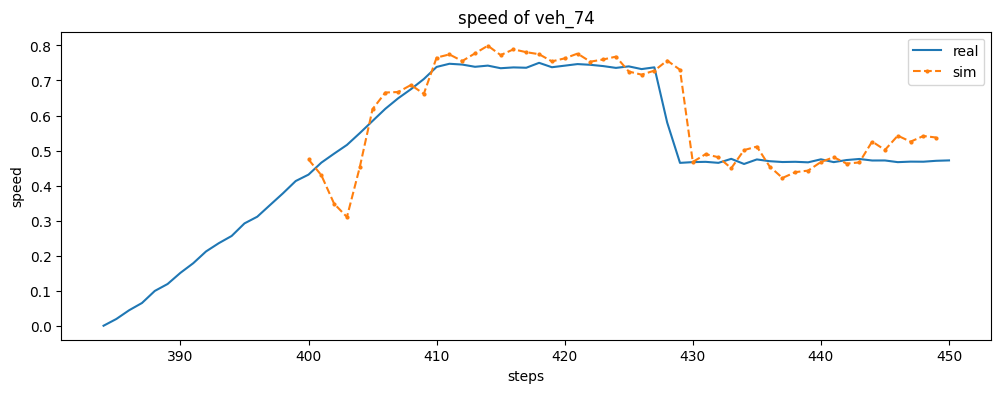

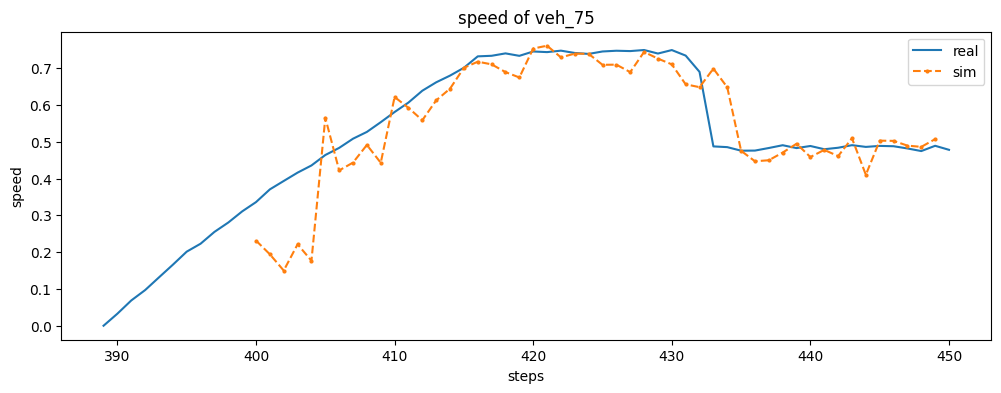

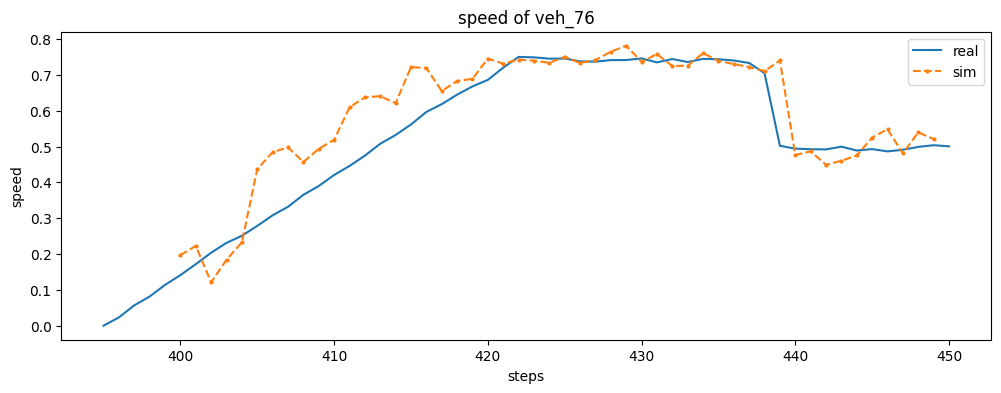

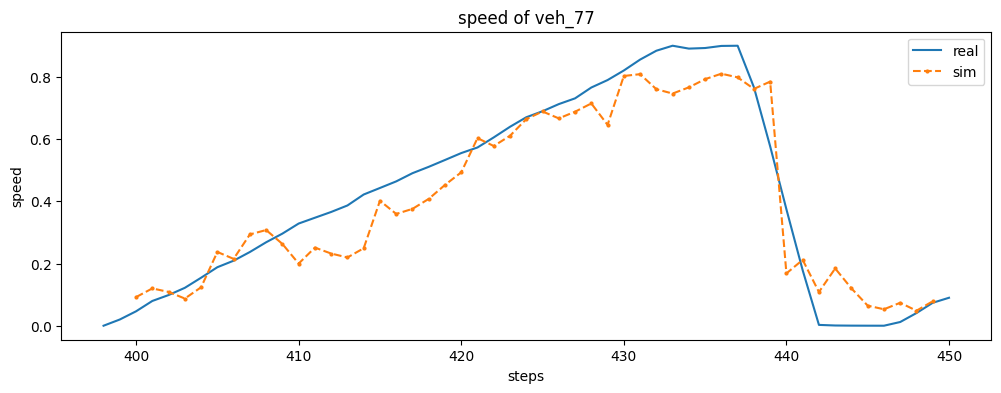

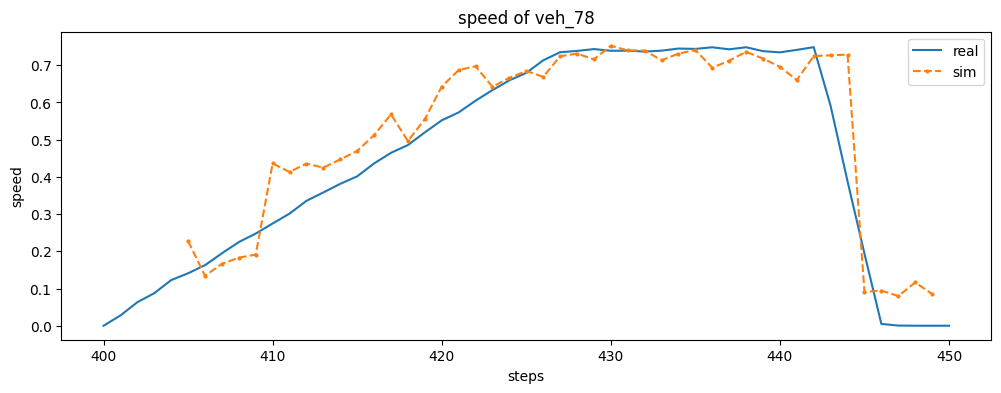

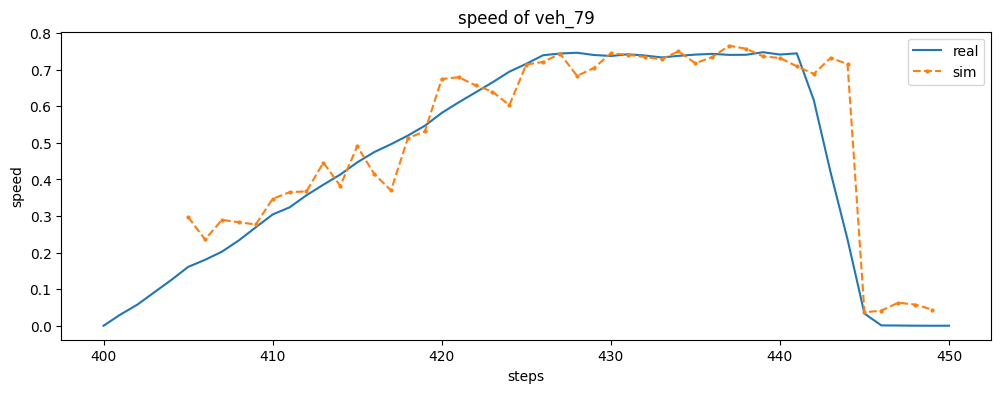

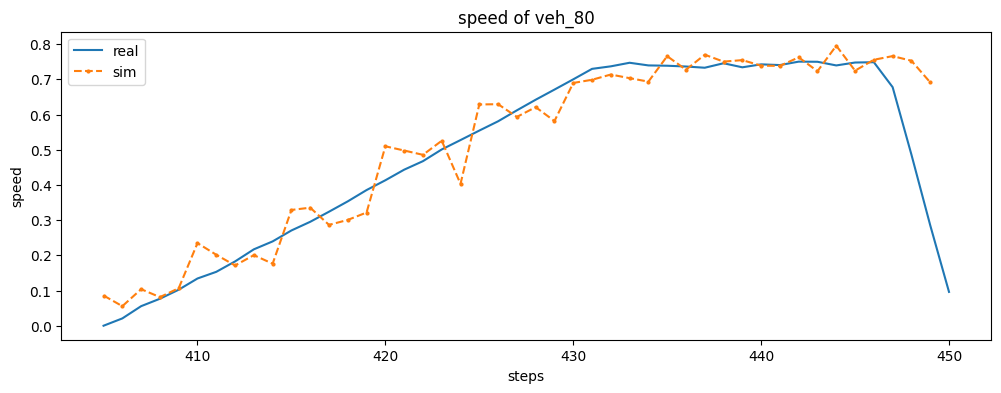

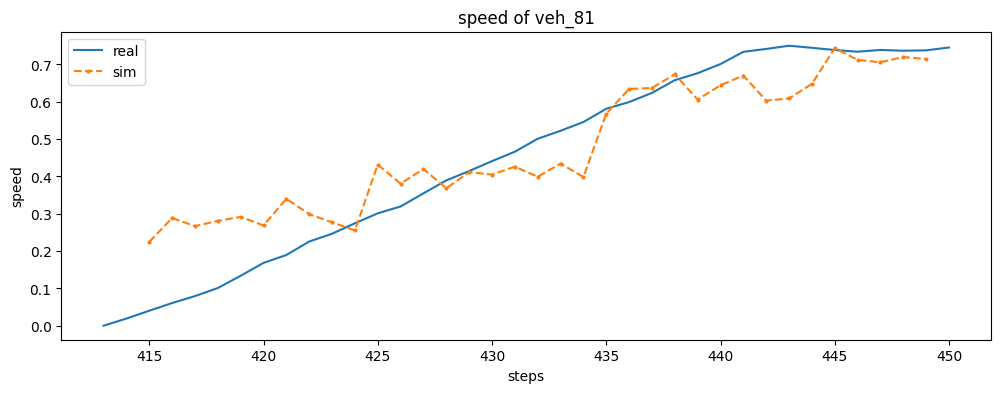

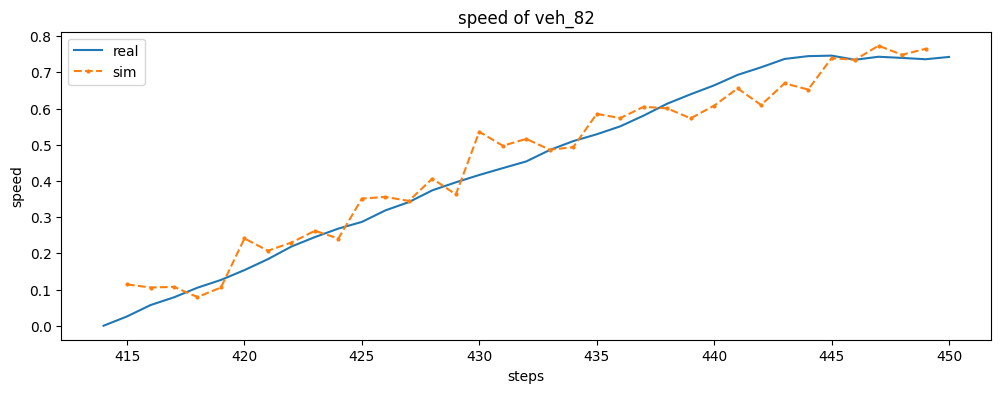

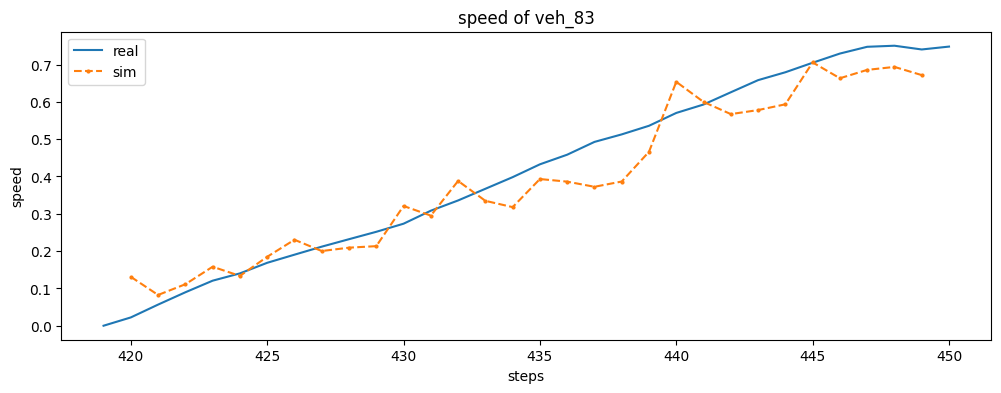

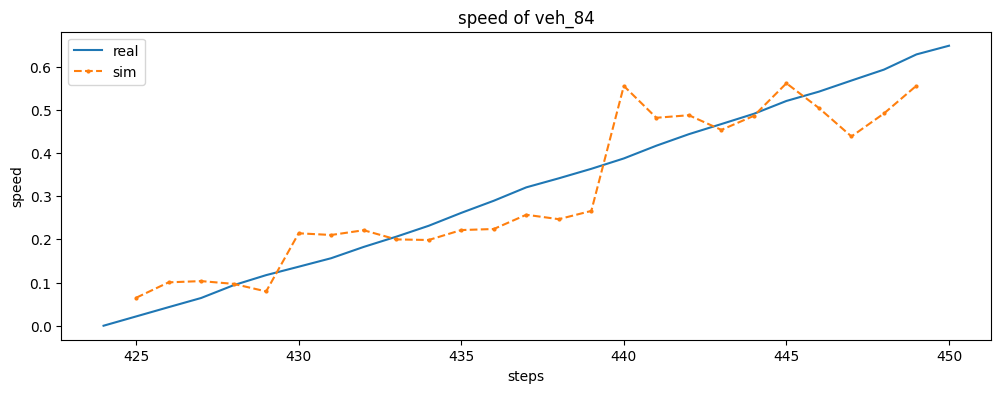

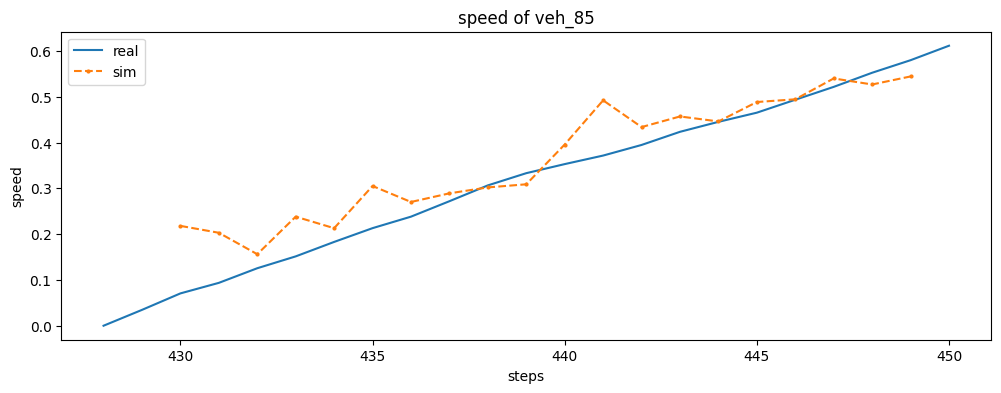

In [113]:
node_type = 'veh'
feat_name = 'speed'
for node_id in common_keys[1:]:
    plot_feat(real_feat,sim_feat,node_type,node_id,feat_name)


/tmp/ipykernel_108700/3897183209.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))


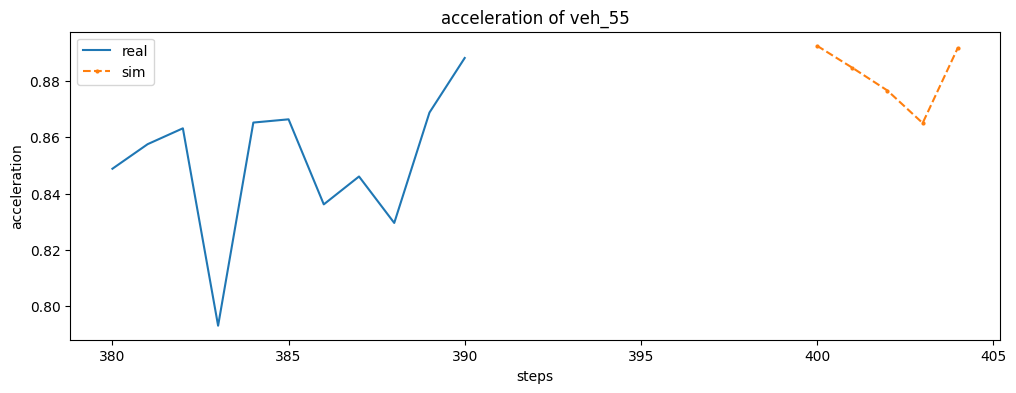

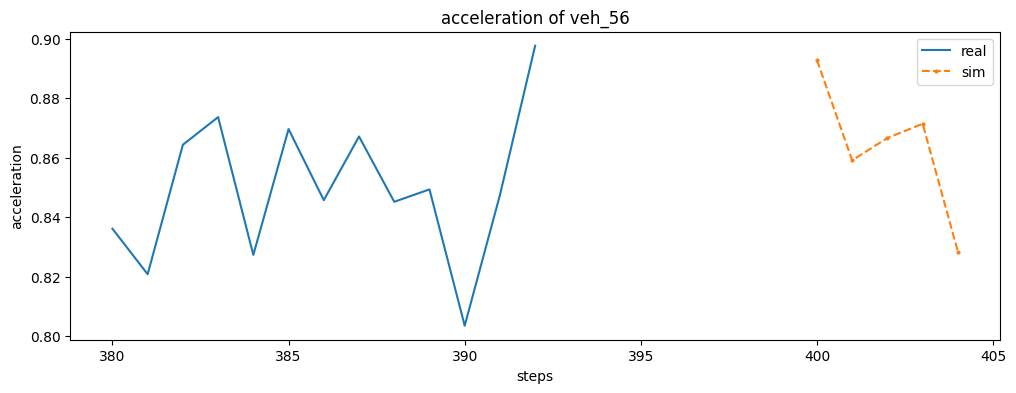

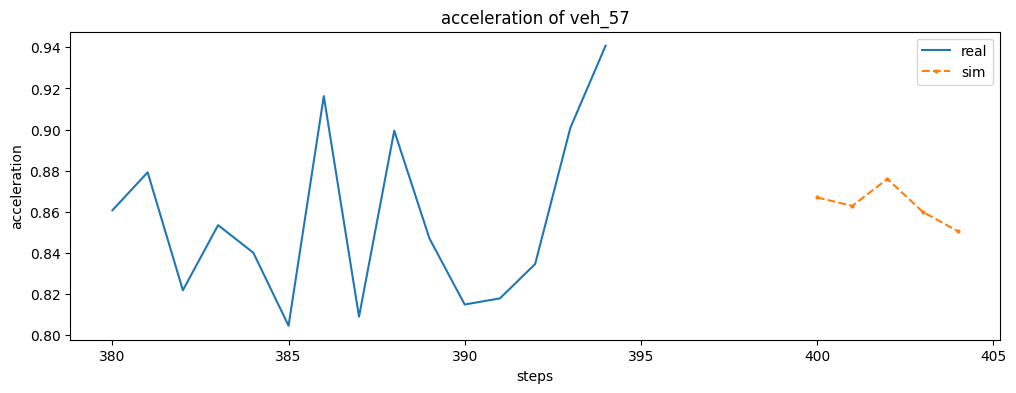

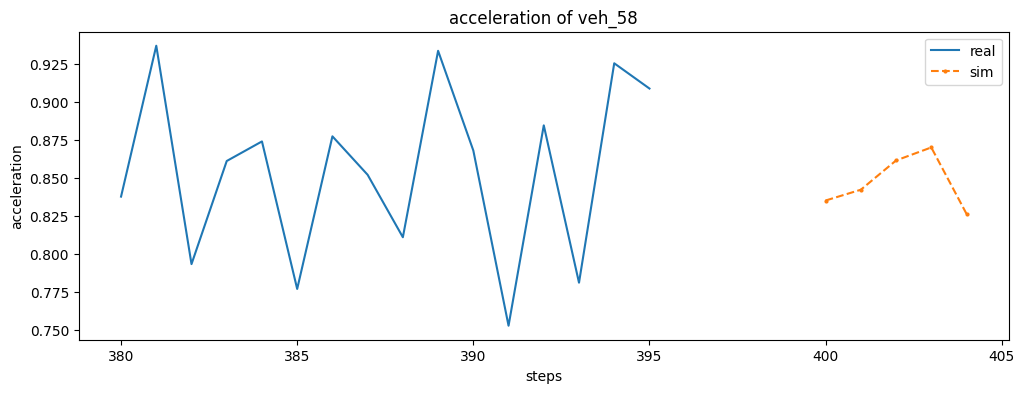

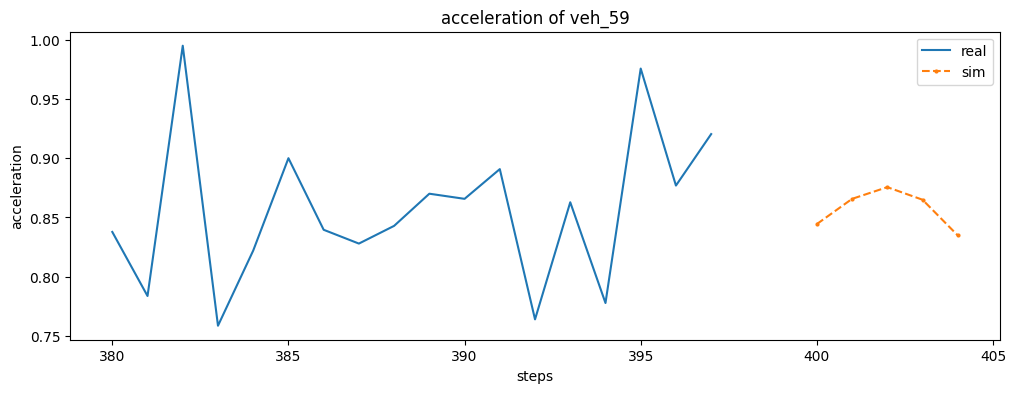

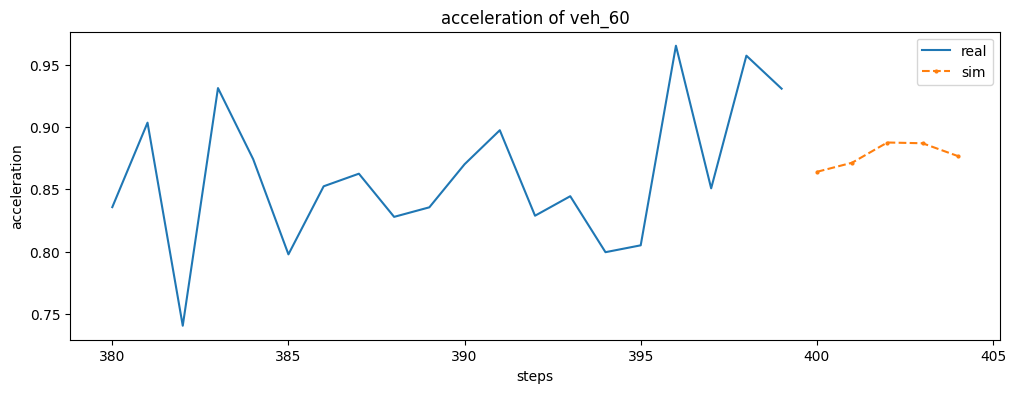

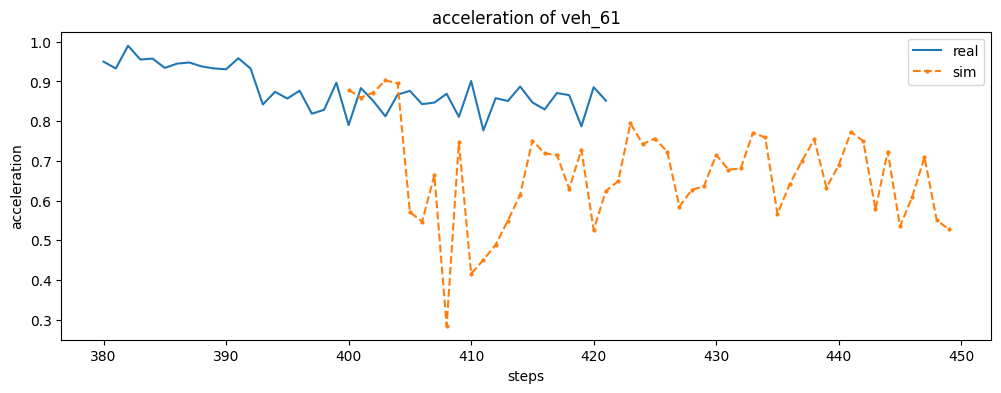

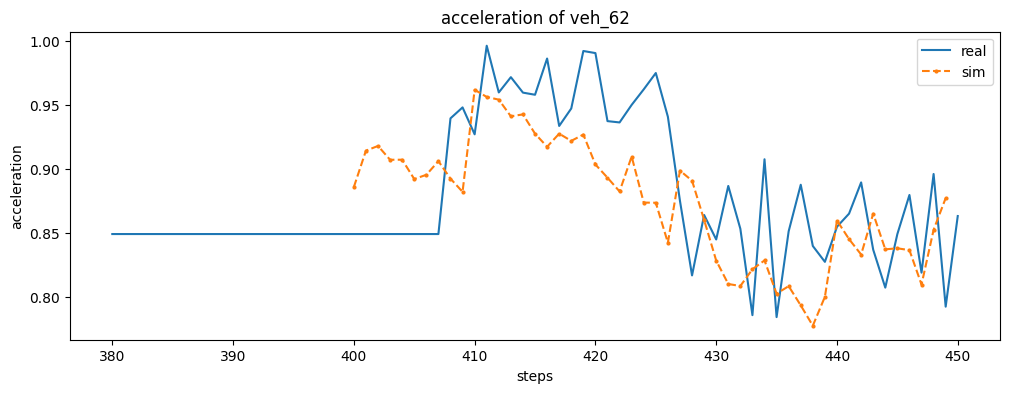

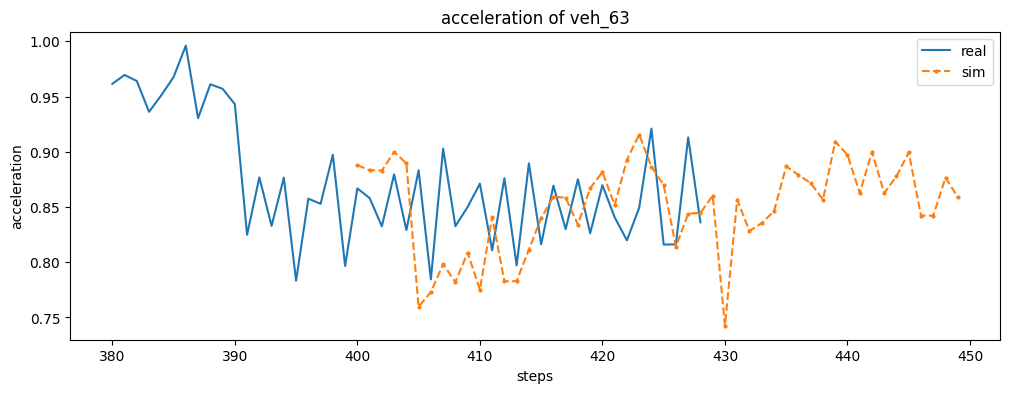

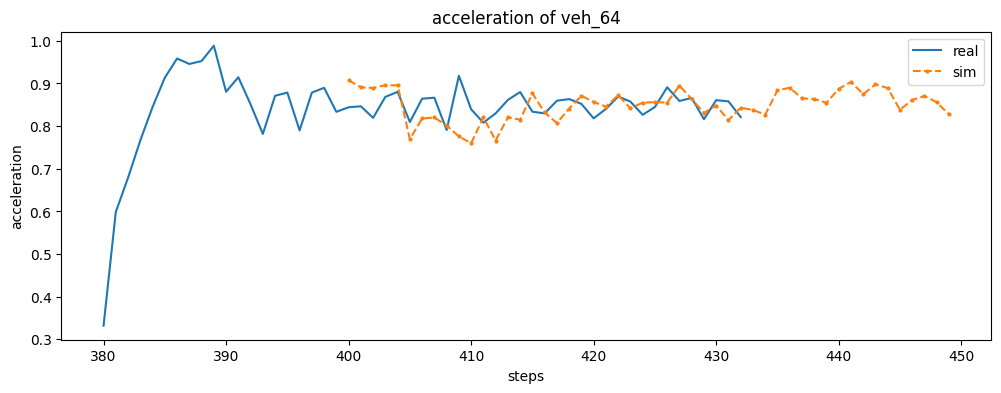

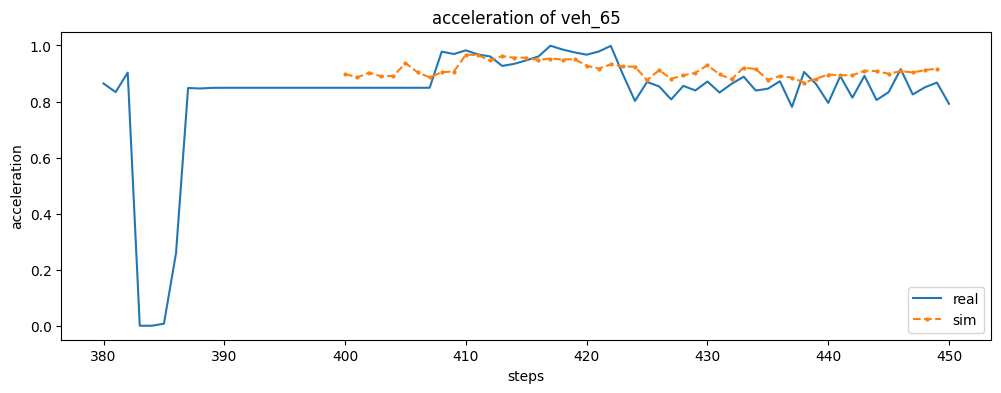

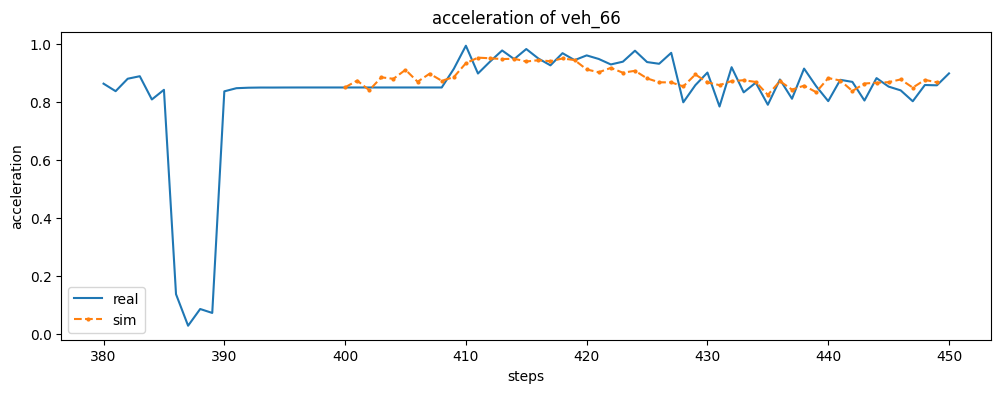

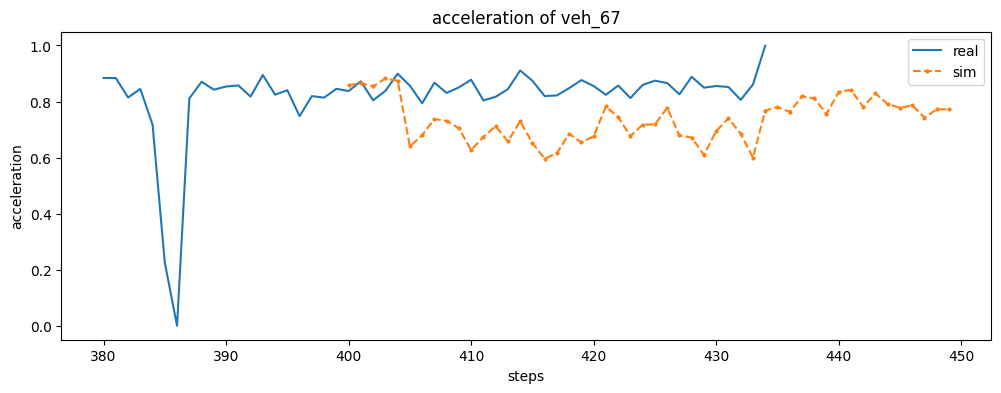

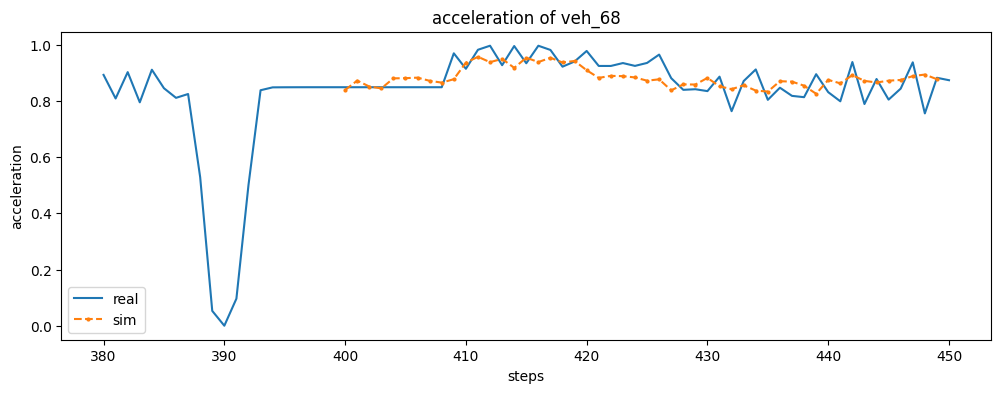

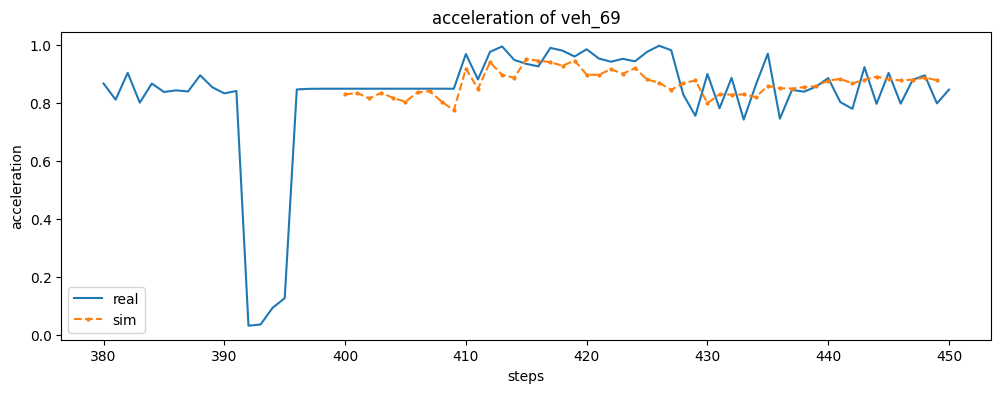

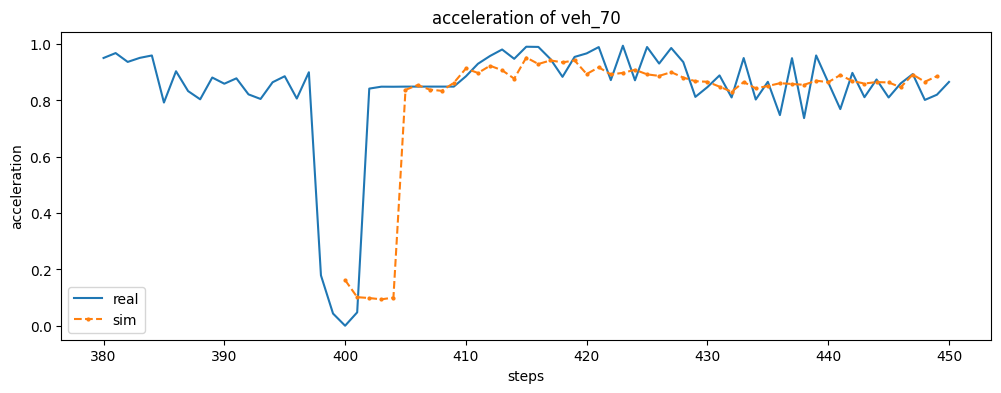

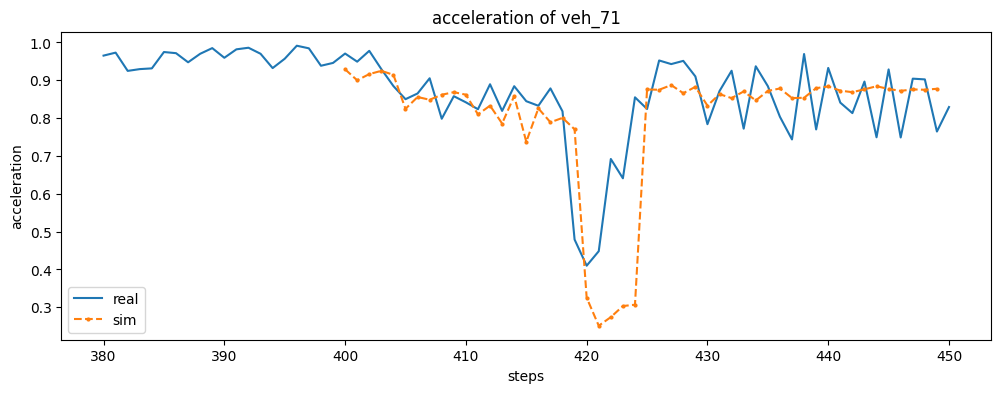

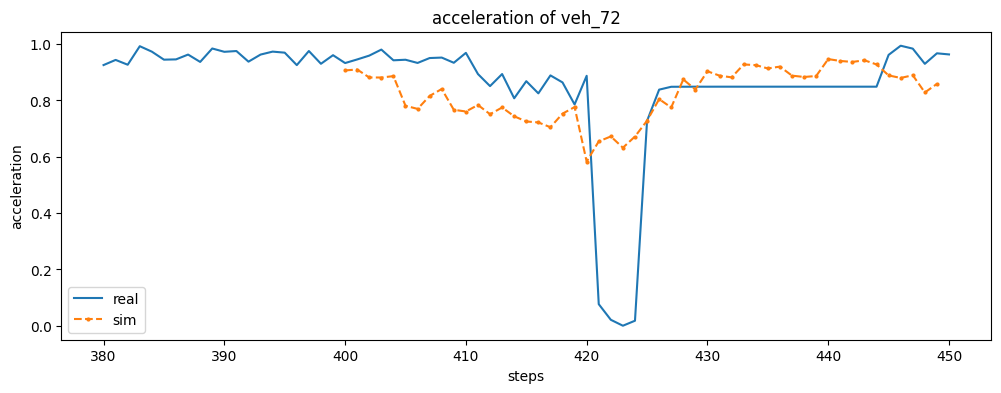

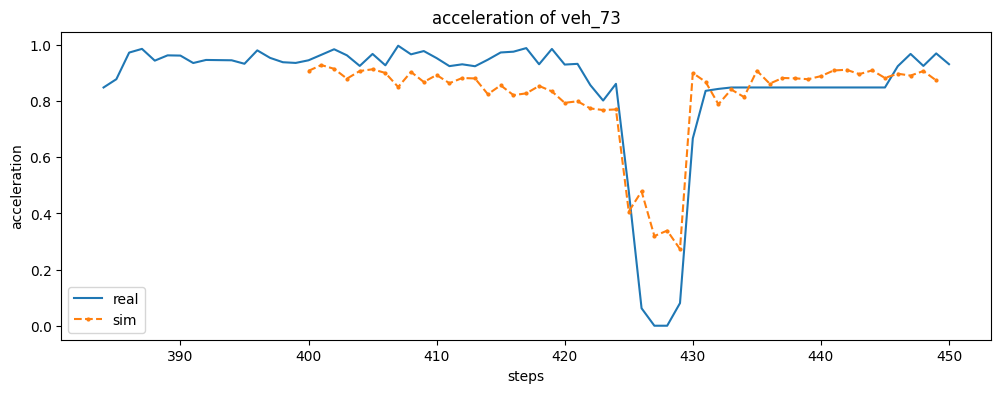

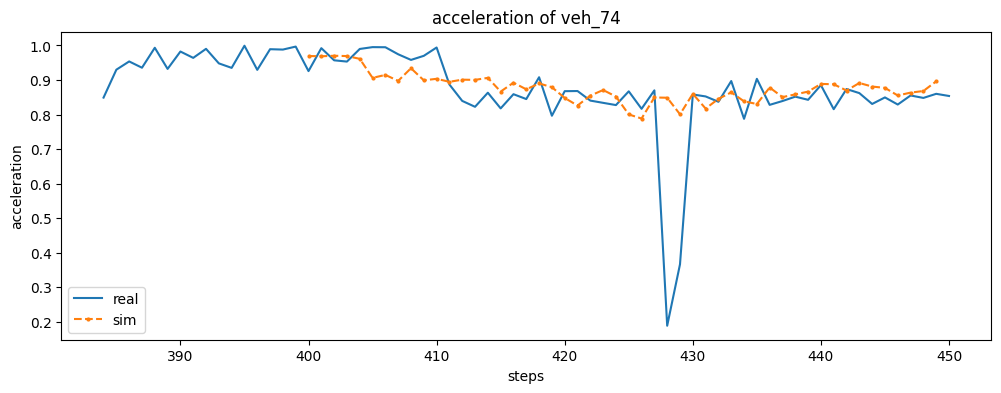

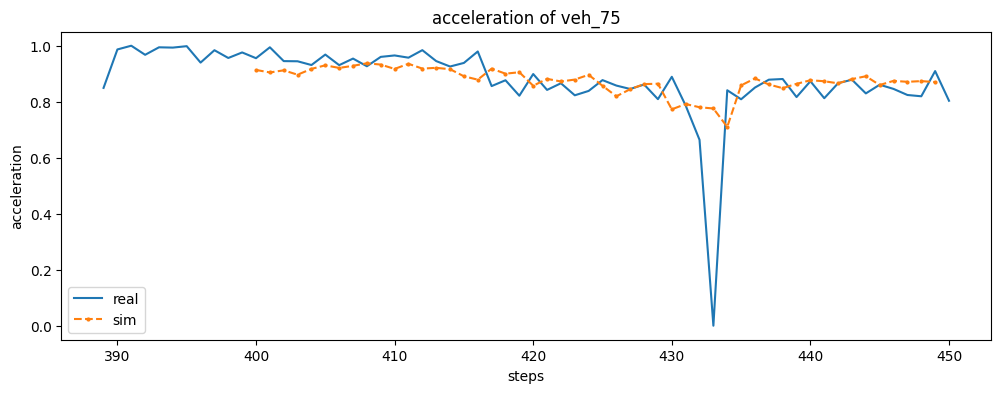

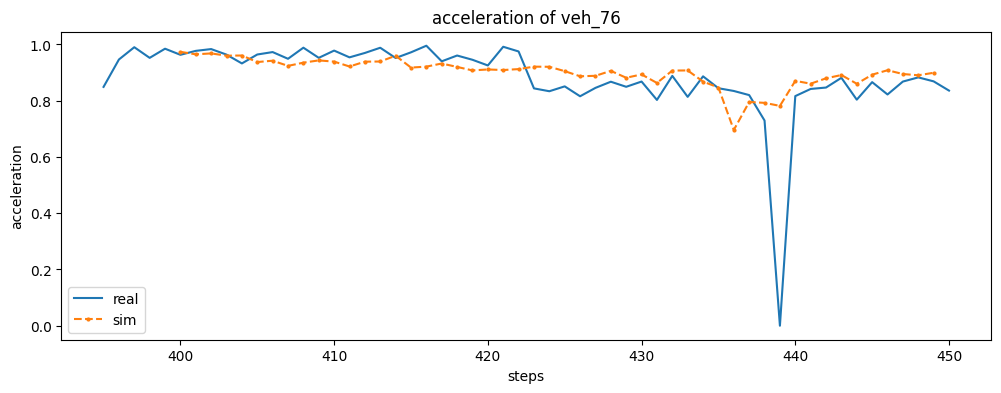

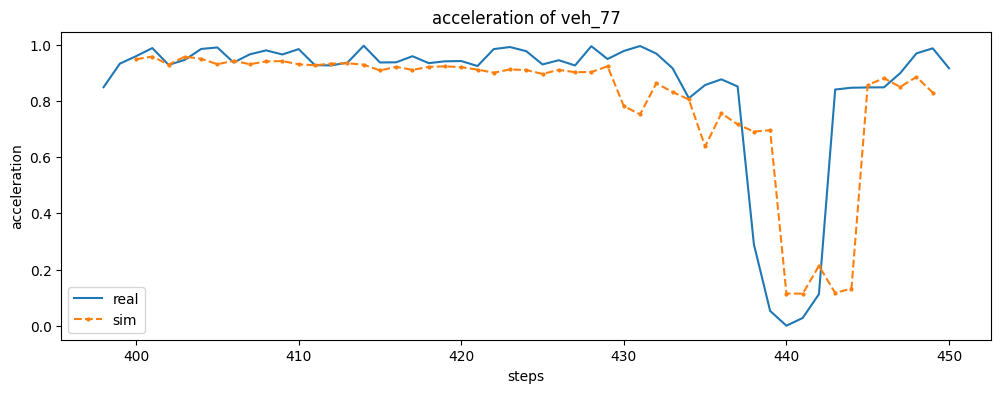

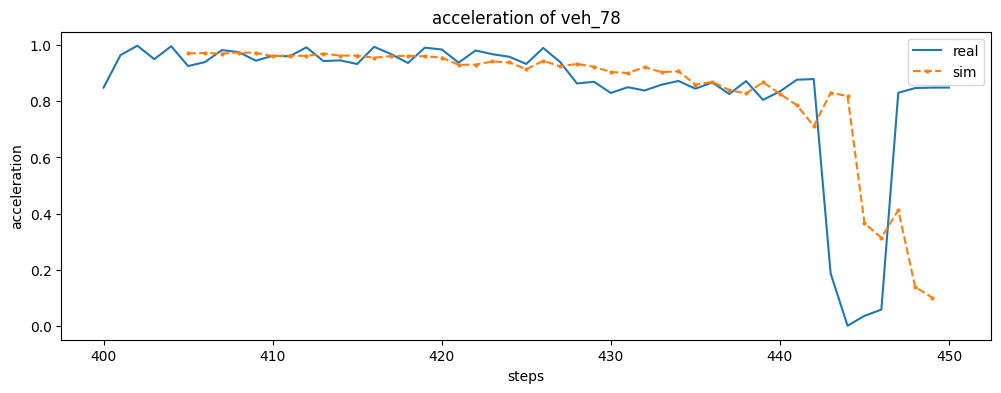

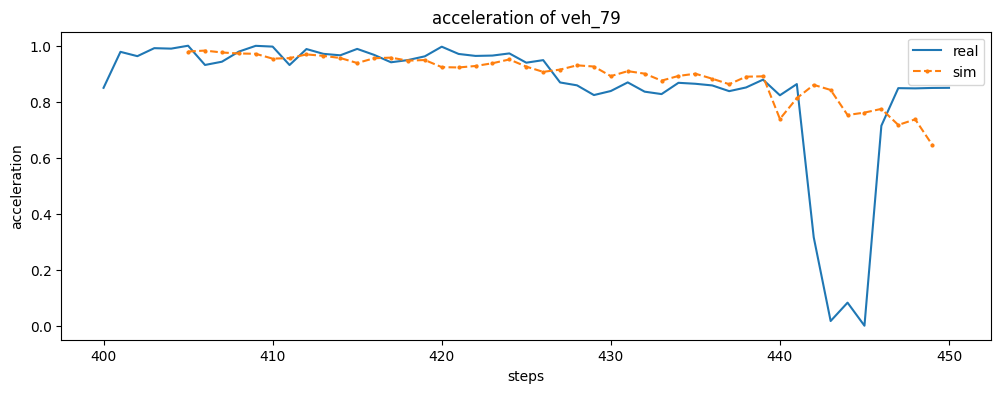

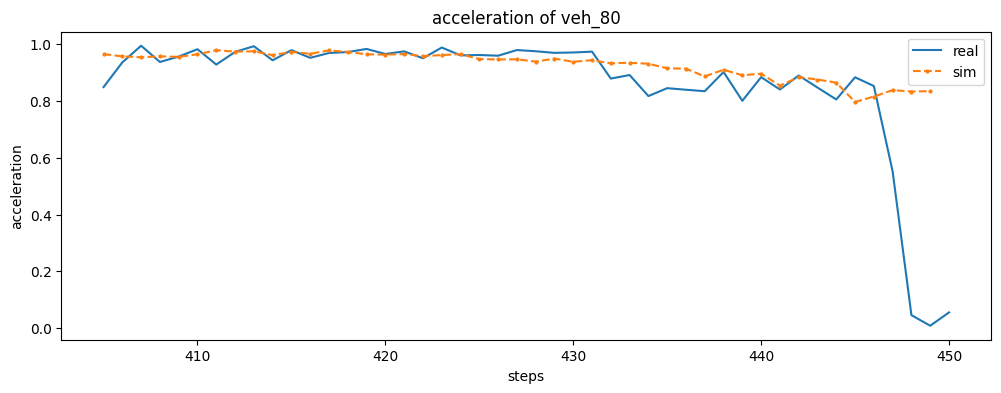

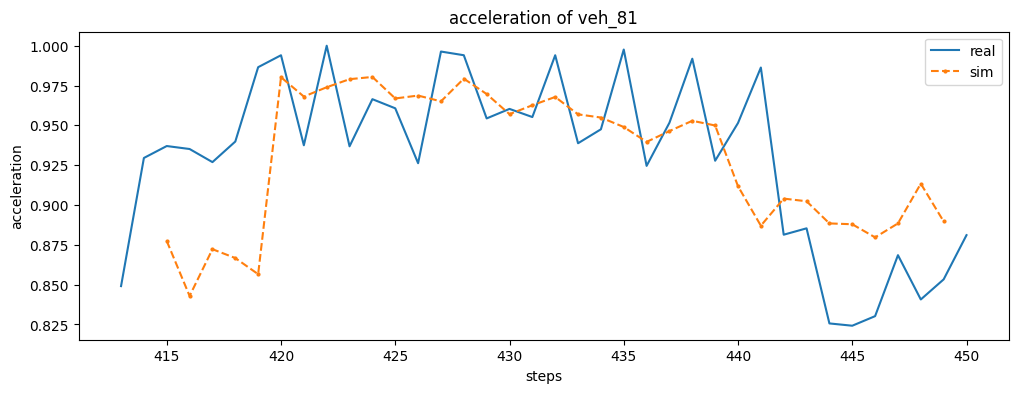

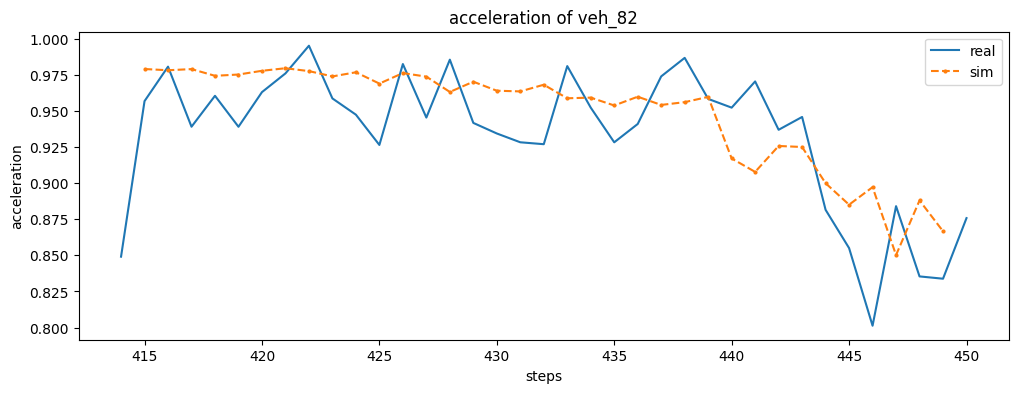

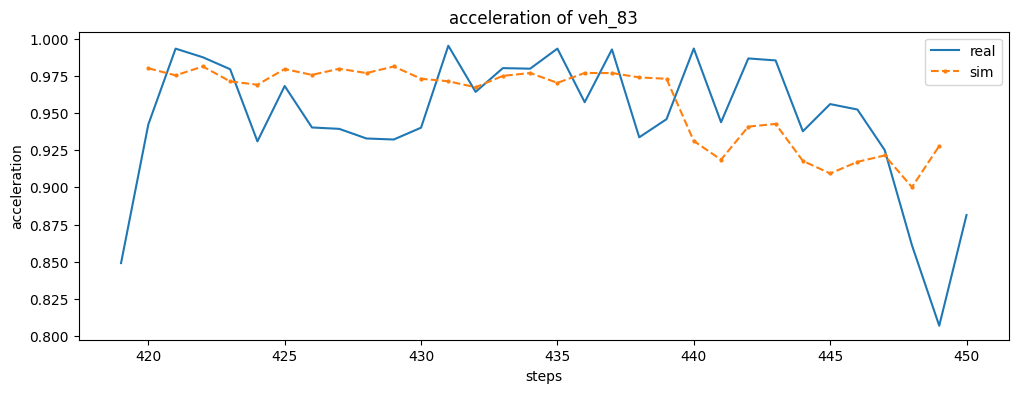

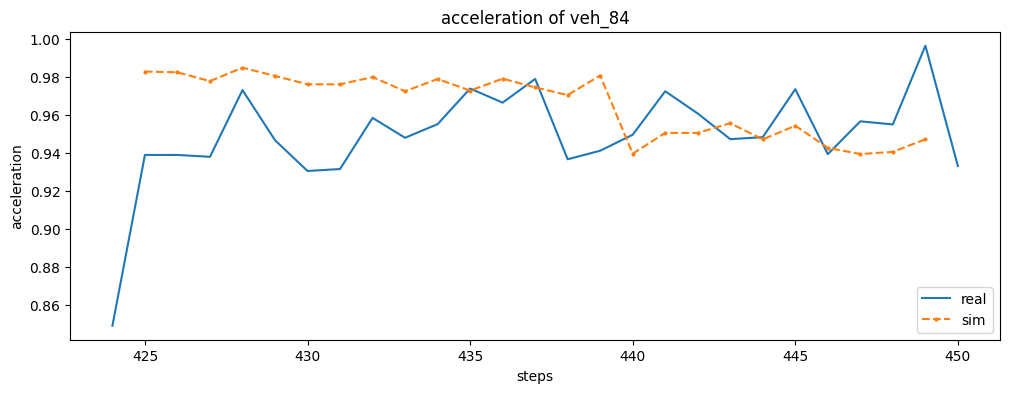

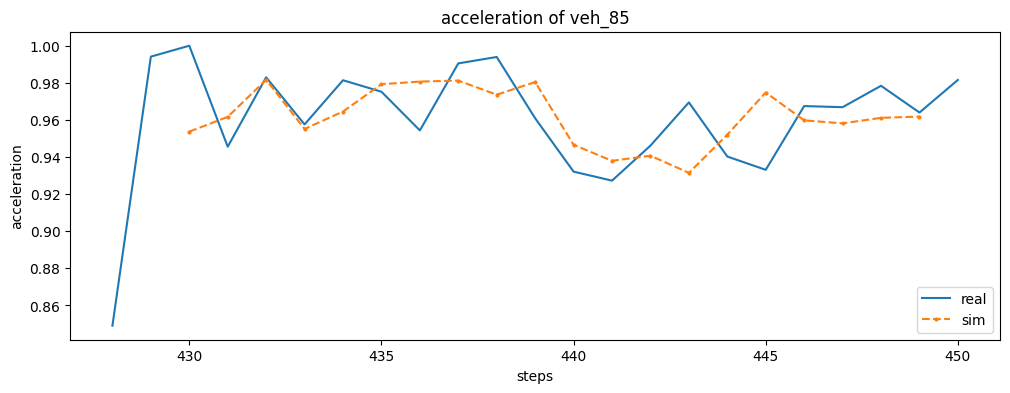

In [114]:
node_type = 'veh'
feat_name = 'acceleration'
for node_id in common_keys[1:]:
    plot_feat(real_feat,sim_feat,node_type,node_id,feat_name)


### Plot feat for single time interval

In [248]:
def sim_feat_preprocess(real_feat, sim_feat, node_type, node_id, feat_name):
    feat_real = get_feat_df(real_feat, node_type, node_id, feat_name)
    feat_sim = get_feat_df(sim_feat, node_type, node_id, feat_name)
    pre_res = feat_real[feat_name+str(node_id)][:prev_step]
    sim_res = feat_sim[feat_name+str(node_id)]
    sim_res = pd.concat([pre_res, sim_res])[:(max(feat_real['time'])-min(feat_real['time']))]
    sim_time = pd.concat([feat_real['time'][:prev_step],feat_sim['time']])[:(max(feat_real['time'])-min(feat_real['time']))]
    return sim_time,sim_res
    

In [249]:

def plot_feat(real_feat, sim_feat, node_type, node_id, feat_name):
    feat_real = get_feat_df(real_feat, node_type, node_id, feat_name)
    sim_time,sim_res = sim_feat_preprocess(real_feat, sim_feat, node_type, node_id, feat_name)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

    ax.plot(feat_real['time'],feat_real[feat_name+str(node_id)], linewidth=2, color='blue', label="SUMO")
    ax.plot(sim_time, sim_res, linestyle='--', linewidth=2, marker='o', markersize=6, color='red', label="TransWorld")
    ax.axvline(x=training_step, linestyle='--', linewidth=1, color='gray')

    ax.set_xlabel("Steps", fontsize=14)
    ax.set_ylabel(feat_name.capitalize(), fontsize=14)  # Capitalize the first letter of feat_name
    #ax.set_title(f"{feat_name.capitalize()} of {node_type}_{node_id}", fontsize=18)  # Capitalize the first letter of feat_name
 
    #ax.set_title(f"{feat_name} of {node_type}_{node_id}", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)

    text_x = max(feat_real['time'])
    text_y = min(feat_real[feat_name+str(node_id)])
    ax.text(text_x, text_y, f"Node type: {node_type}\nNode ID: {node_id}\nFeature name: {feat_name}\nTraining step: 0~{training_step}", fontsize=14, ha='right', va='bottom')

    # Add "Training" and "Evaluation" text
    ax.text(training_step-5, 1, "Training", fontsize=12, ha="right")
    ax.text(training_step+5, 1, "Evaluation", fontsize=12, ha="left")

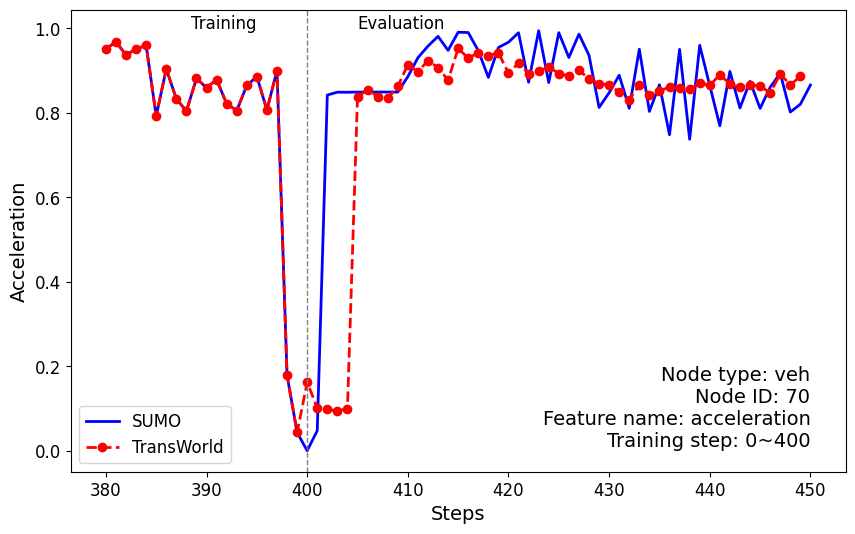

In [250]:
node_type = 'veh'
feat_name = 'acceleration'
node_id = 70

plot_feat(real_feat,sim_feat,node_type,node_id,feat_name)

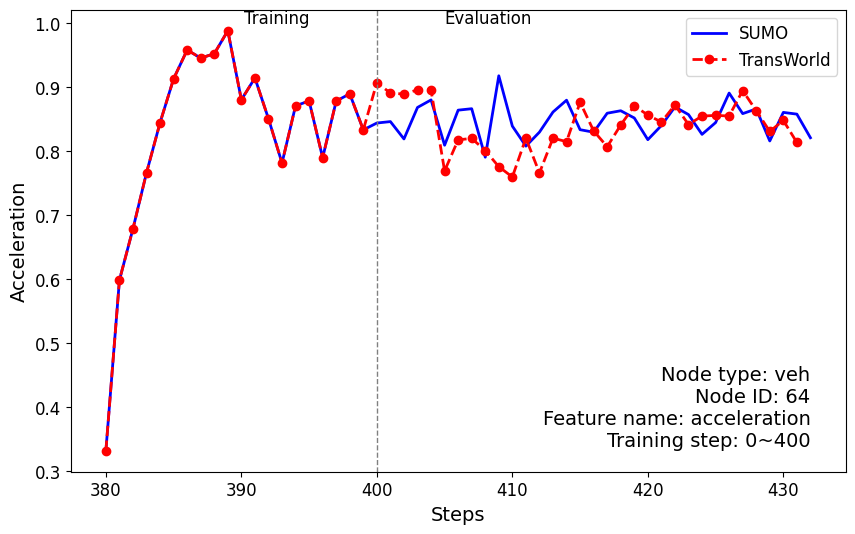

In [251]:
node_type = 'veh'
feat_name = 'acceleration'
node_id = 64

plot_feat(real_feat,sim_feat,node_type,node_id,feat_name)

### Plot different time interval

In [252]:

def plot_feat(real_feat, sim_feat_2, sim_feat_5, sim_feat_10, node_type, node_id, feat_name):
    feat_real = get_feat_df(real_feat, node_type, node_id, feat_name)
    sim_time_2,sim_res_2 = sim_feat_preprocess(real_feat, sim_feat_2, node_type, node_id, feat_name)
    sim_time_5,sim_res_5 = sim_feat_preprocess(real_feat, sim_feat_5, node_type, node_id, feat_name)
    sim_time_10,sim_res_10 = sim_feat_preprocess(real_feat, sim_feat_10, node_type, node_id, feat_name)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

    ax.plot(feat_real['time'],feat_real[feat_name+str(node_id)], linewidth=2, color='blue', label="SUMO")
    ax.plot(sim_time_2,sim_res_2, linestyle='--', linewidth=2, marker='o', markersize=6, color='red', label="TransWorld")
    ax.plot(sim_time_5,sim_res_5, linestyle='--', linewidth=2, marker='o', markersize=6, color='red', label="TransWorld")
    ax.plot(sim_time_10,sim_res_10, linestyle='--', linewidth=2, marker='o', markersize=6, color='red', label="TransWorld")
  
    ax.axvline(x=training_step, linestyle='--', linewidth=1, color='gray')

    ax.set_xlabel("Steps", fontsize=14)
    ax.set_ylabel(feat_name.capitalize(), fontsize=14)  # Capitalize the first letter of feat_name
    #ax.set_title(f"{feat_name.capitalize()} of {node_type}_{node_id}", fontsize=18)  # Capitalize the first letter of feat_name
 
    #ax.set_title(f"{feat_name} of {node_type}_{node_id}", fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=12)
    ax.legend(fontsize=12)

    text_x = max(feat_real['time'])
    text_y = min(feat_real[feat_name+str(node_id)])
    ax.text(text_x, text_y, f"Node type: {node_type}\nNode ID: {node_id}\nFeature name: {feat_name}\nTraining step: 0~{training_step}", fontsize=14, ha='right', va='bottom')

    # Add "Training" and "Evaluation" text
    ax.text(training_step-5, 1, "Training", fontsize=12, ha="right")
    ax.text(training_step+5, 1, "Evaluation", fontsize=12, ha="left")

In [253]:
training_step = 400
prev_step = 20
case, test =  "traci_tls","test2"
out_pre = "out_dim_50_n_heads_4_n_layer_4_pred_step_"

pred_step = 2
out = out_pre + str(pred_step)
sim_feat_2 = load_data(case,test,out,training_step,pred_step)

pred_step = 5
out = out_pre + str(pred_step)
sim_feat_2 = load_data(case,test,out,training_step,pred_step)

pred_step = 10
out = out_pre + str(pred_step)
sim_feat_2 = load_data(case,test,out,training_step,pred_step)

FileNotFoundError: [Errno 2] No such file or directory: '/nvme/wangding/Desktop/tsim/experiment/traci_tls/data/test2/out_dim_50_n_heads_4_n_layer_4_pred_step_2'

In [ ]:
node_type = 'veh'
feat_name = 'acceleration'
node_id = 64

plot_feat(real_feat, sim_feat_2, sim_feat_5, sim_feat_10, node_type, node_id, feat_name)